In [1]:
# Python packages
import warnings
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

sc.set_figure_params(dpi = 120)

In [2]:
os.chdir('/mnt/g/scParadise/scripts_article/')

## Data preparation
Here we download and preprocess dataset from cellxgene: <br> 

Single cell RNA sequencing of oropharyngeal squamous cell carcinoma <br>
https://cellxgene.cziscience.com/collections/3c34e6f1-6827-47dd-8e19-9edcd461893f

In [2]:
!wget https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad

--2025-05-13 15:32:24--  https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad
52.85.49.28, 52.85.49.24, 52.85.49.17, ...m (datasets.cellxgene.cziscience.com)... 
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|52.85.49.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981941987 (936M) [binary/octet-stream]
Saving to: ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’

915069db-1df2-49a1- 100%[===================>] 936.45M  3.17MB/s    in 5m 14s  

2025-05-13 15:37:40 (2.98 MB/s) - ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’ saved [981941987/981941987]



In [3]:
# Load prepared for training anndata object
adata = sc.read_h5ad('915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad')

In [4]:
# Get raw counts from adata.raw
adata = adata.raw.to_adata()

In [5]:
# Convert var_names from ENSG codes to gene names
adata.var.set_index('feature_name', inplace=True)
adata.var_names_make_unique()

In [5]:
# Select datasets for model training and testing
# It is necessary for all cell types to be present in both the training datasets and the testing datasets
df = scparadise.scnoah.cell_counter(adata, celltype='cell_type', sample='donor_id')
df

HN481  HN482  HN483  HN485  HN487  \
epithelial cell                        6747    758    934    575   2061   
plasma cell                             868   1051    498    609    106   
CD8-positive, alpha-beta T cell         613   1129   1204    740    279   
fibroblast                              512    164    256    163    371   
myeloid cell                            415    311    159    361    995   
regulatory T cell                       370    316    623    351    135   
endothelial cell                        283    174    144    111    122   
CD4-positive, alpha-beta T cell         282   1272   2629    911     87   
mural cell                              267    170     98    156    195   
B cell                                  213   1837   3369    764     30   
mast cell                                92     56     91     56     20   
natural killer cell                      88    135    205     65     40   
mature alpha-beta T cell                 44     31     13      7      8   
endothelial cell of lymphatic vessel     29     23     25     10      8   
plasmacytoid dendritic cell              19     31     43     25     13   

                                      HN488  HN489  HN490  HN492  HN494  
epithelial cell                        1335   2533   2955   2619    780  
plasma cell                             596   1005    975    642    579  
CD8-positive, alpha-beta T cell         941   1004    472   1408    911  
fibroblast                              118    856    204    234    560  
myeloid cell                            136    929    394    203   2998  
regulatory T cell                        69    881    385    321    616  
endothelial cell                        152    311    240    135    138  
CD4-positive, alpha-beta T cell         224   1310   1076    789   1784  
mural cell                              173    286    233     87    128  
B cell                                 2053   1338   2297    942   1832  
mast cell                                39     33     29     74     27  
natural killer cell                     120    465     94     58    128  
mature alpha-beta T cell                  7     82     30     38     42  
endothelial cell of lymphatic vessel      9     59      6     28      8  
plasmacytoid dendritic cell              22     87     24     20    163

In [ ]:
# Save counts data to use Seurat and Azimuth
import scipy
adata.layers['counts'] = adata.X.copy()
# Save raw filtered counts and meta data for Azimuth
destination = 'Oropharyngeal_cancer'
adata.obs.to_csv(os.path.join(destination, "metadata.csv"))
# RNA
destination = 'Oropharyngeal_cancer/RNA'
pd.DataFrame(index = adata.var.index).to_csv(os.path.join(destination, "features.tsv" ), sep = "\t", header=False)
pd.DataFrame(index = adata.obs.index).to_csv(os.path.join(destination, "barcodes.tsv"), sep = "\t", header=False)
scipy.io.mmwrite(os.path.join(destination, "matrix.mtx"), adata.layers['counts'].T)

In [6]:
# Create adata_train1, adata_train2 and adata_test datasets
adata_test_1 = adata[adata.obs['donor_id'].isin(['HN490'])].copy()
adata_test_2 = adata[adata.obs['donor_id'].isin(['HN492'])].copy()
adata_test_3 = adata[adata.obs['donor_id'].isin(['HN482'])].copy()
adata_test_4 = adata[adata.obs['donor_id'].isin(['HN488'])].copy()
adata_test_5 = adata[adata.obs['donor_id'].isin(['HN485'])].copy()
adata_test_6 = adata[adata.obs['donor_id'].isin(['HN487'])].copy()
adata_test_7 = adata[adata.obs['donor_id'].isin(['HN483'])].copy()
adata_test_8 = adata[adata.obs['donor_id'].isin(['HN489'])].copy()
adata_train_1 = adata[adata.obs['donor_id'].isin(['HN481'])].copy()
adata_train_2 = adata[adata.obs['donor_id'].isin(['HN494'])].copy()
#del adata

In [7]:
# Normalize data, find highly variable features
for i in [adata_train_1, adata_train_2, adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6, adata_test_7, adata_test_8]:
    i.layers['counts'] = i.X.copy()
    sc.pp.normalize_total(i, target_sum=None)
    sc.pp.log1p(i)
    i.raw = i

In [8]:
# Find genes for model training (marker genes of cell types)
lst_genes = []
annotations = ['cell_type'] # annotation levels
for annotation in annotations:
    sc.tl.rank_genes_groups(adata_train_1, 
                            groupby = annotation,
                            method = 't-test_overestim_var', pts = True)
    # Filter marker genes of cell types
    sc.tl.filter_rank_genes_groups(adata_train_1, 
                                   min_fold_change = 1.0, 
                                   min_in_group_fraction = 0.4,
                                   key_added = 'filtered_rank_genes_groups')
    # Create list of genes for model training

    for i in adata.obs[annotation].unique():
        df = sc.get.rank_genes_groups_df(adata_train_1, group = i, key = 'filtered_rank_genes_groups', pval_cutoff = 0.05)
        df['pts_comparizon'] = df['pct_nz_group']/df['pct_nz_reference']
        lst_genes.extend(df.sort_values(by = 'logfoldchanges', ascending = False).head(50)['names'].tolist())
        lst_genes.extend(df.sort_values(by = 'pts_comparizon', ascending = False).head(50)['names'].tolist())
# Remove duplicates 
lst_genes = np.unique(lst_genes).tolist()
len(lst_genes)

622

In [9]:
df_genes = pd.DataFrame(lst_genes, columns = ['genes'])
df_genes.to_csv('Oropharyngeal_cancer/genes_for_AI.csv')

In [8]:
# Subset anndata object based on a selected marker genes
genes = pd.read_csv('Oropharyngeal_cancer/genes_for_AI.csv')
adata_train_1 = adata_train_1[:, genes.genes].copy()

## Default model training
Use 'balanced_accuracy' as the evaluation metric in this case due to the imbalance in the number of cells among cell types.

In [9]:
adata_train_1_balanced = scparadise.scnoah.balance(adata_train_1, 
                                                   sample='donor_id',
                                                   celltype_l1='cell_type')

Successfully undersampled cell types: epithelial cell, plasma cell

Successfully oversampled cell types: CD8-positive, alpha-beta T cell, fibroblast, myeloid cell, regulatory T cell, endothelial cell, CD4-positive, alpha-beta T cell, mural cell, B cell, mast cell, natural killer cell, mature alpha-beta T cell, endothelial cell of lymphatic vessel, plasmacytoid dendritic cell


In [59]:
# Train scadam model using adata_train1 dataset
scparadise.scadam.train(adata_train_1_balanced,
                        path='', # path to save model
                        model_name='model_oropharyngeal_cancer_scadam_default', # folder name with model
                        celltype_l1='celltype_l1',
                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 9760 cells, it is 90.0 % of input dataset
Test dataset contains: 1085 cells, it is 10.0 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 10.44382| val_0_unsup_loss_numpy: 1.2051199674606323|  0:00:00s
epoch 1  | loss: 2.6394  | val_0_unsup_loss_numpy: 1.1570600271224976|  0:00:00s
epoch 2  | loss: 1.33682 | val_0_unsup_loss_numpy: 1.11503005027771|  0:00:01s
epoch 3  | loss: 1.09411 | val_0_unsup_loss_numpy: 1.0294899940490723|  0:00:01s
epoch 4  | loss: 1.02358 | val_0_unsup_loss_numpy: 1.0074199438095093|  0:00:02s
epoch 5  | loss: 1.00128 | val_0_unsup_loss_numpy: 0.9938300251960754|  0:00:02s
epoch 6  | loss: 0.98918 | val_0_unsup_loss_numpy: 0.9713799953460693|  0:00:03s
epoch 7  | loss: 0.96747 | val_0_unsup_loss_numpy: 0.937749981880188|  0:00:03s
epoch 8  | loss: 0.94751 | val_0_unsup_loss_numpy: 0.9184200167655945|  

### Evaluation of model quality

In [38]:
lst_test_folders = ['HN490', 'HN492', 'HN482', 'HN488', 'HN485', 'HN487', 'HN483', 'HN489']
lst_test_adatas = [adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6, adata_test_7, adata_test_8]

In [39]:
# Predict cell types using trained model
for adata_test, j in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Oropharyngeal_cancer/scadam_default', j))
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_oropharyngeal_cancer_scadam_default')
    df_default = scparadise.scnoah.report_classif_full(adata_test,
                                                       celltype='cell_type',
                                                       pred_celltype='pred_celltype_l1',
                                                       report_name='report_test_scadam_default_' + 'cell_type' + '.csv',
                                                       save_path = os.path.join('Oropharyngeal_cancer/scadam_default', j).replace("\\","/"),
                                                       save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [60]:
adata_test_8 = scparadise.scadam.predict(adata_test_8, 
                                         path_model = 'model_oropharyngeal_cancer_scadam_default')
# Order cell type colors
celltype = np.unique(adata_test_8.obs['cell_type']).tolist()
adata_test_8.obs['cell_type'] = pd.Categorical(
    values=adata_test_8.obs['cell_type'], categories=celltype, ordered=True
)
adata_test_8.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test_8.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_8, celltype='cell_type', pred_celltype='pred_celltype_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


In [61]:
cluster_list = adata_test_8.obs['cell_type'].unique()
# Make cluster anottation dictionary
# Only to make cell type names shorter
annotation = {"Plasma":['plasma cell'],
              "CD4 T": ['CD4-positive, alpha-beta T cell'],
              'Epithelial':['epithelial cell'],
              "B":['B cell'],
              "NK" :['natural killer cell'],
              "Endothelial":['endothelial cell'],
              "T reg":['regulatory T cell'],
              "pDC":['plasmacytoid dendritic cell'],
              "Myeloid":['myeloid cell'],
              "CD8 T":['CD8-positive, alpha-beta T cell'],
              "Mural ":['mural cell'],
              "Fibroblast":['fibroblast'],
              "Lymphatic":['endothelial cell of lymphatic vessel'],
              "Mast":['mast cell'],
              "T mature":['mature alpha-beta T cell']
             }

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if i in annotation[k]:
            annotation_rev[i] = k

adata_test_8.obs["renamed_cell_type"] = [annotation_rev[i] for i in adata_test_8.obs['cell_type']]
adata_test_8.obs["renamed_pred_celltype_l1"] = [annotation_rev[i] for i in adata_test_8.obs['pred_celltype_l1']]
adata_test_8 = adata_test_8[adata_test_8.obs['pred_status'].sort_values().index,:]

In [47]:
sc.pp.highly_variable_genes(adata_test_8,
                            n_top_genes=2000,
                            subset=False)
sc.pp.pca(adata_test_8)
sc.pp.neighbors(adata_test_8, n_pcs=20)
sc.tl.umap(adata_test_8, min_dist=1)

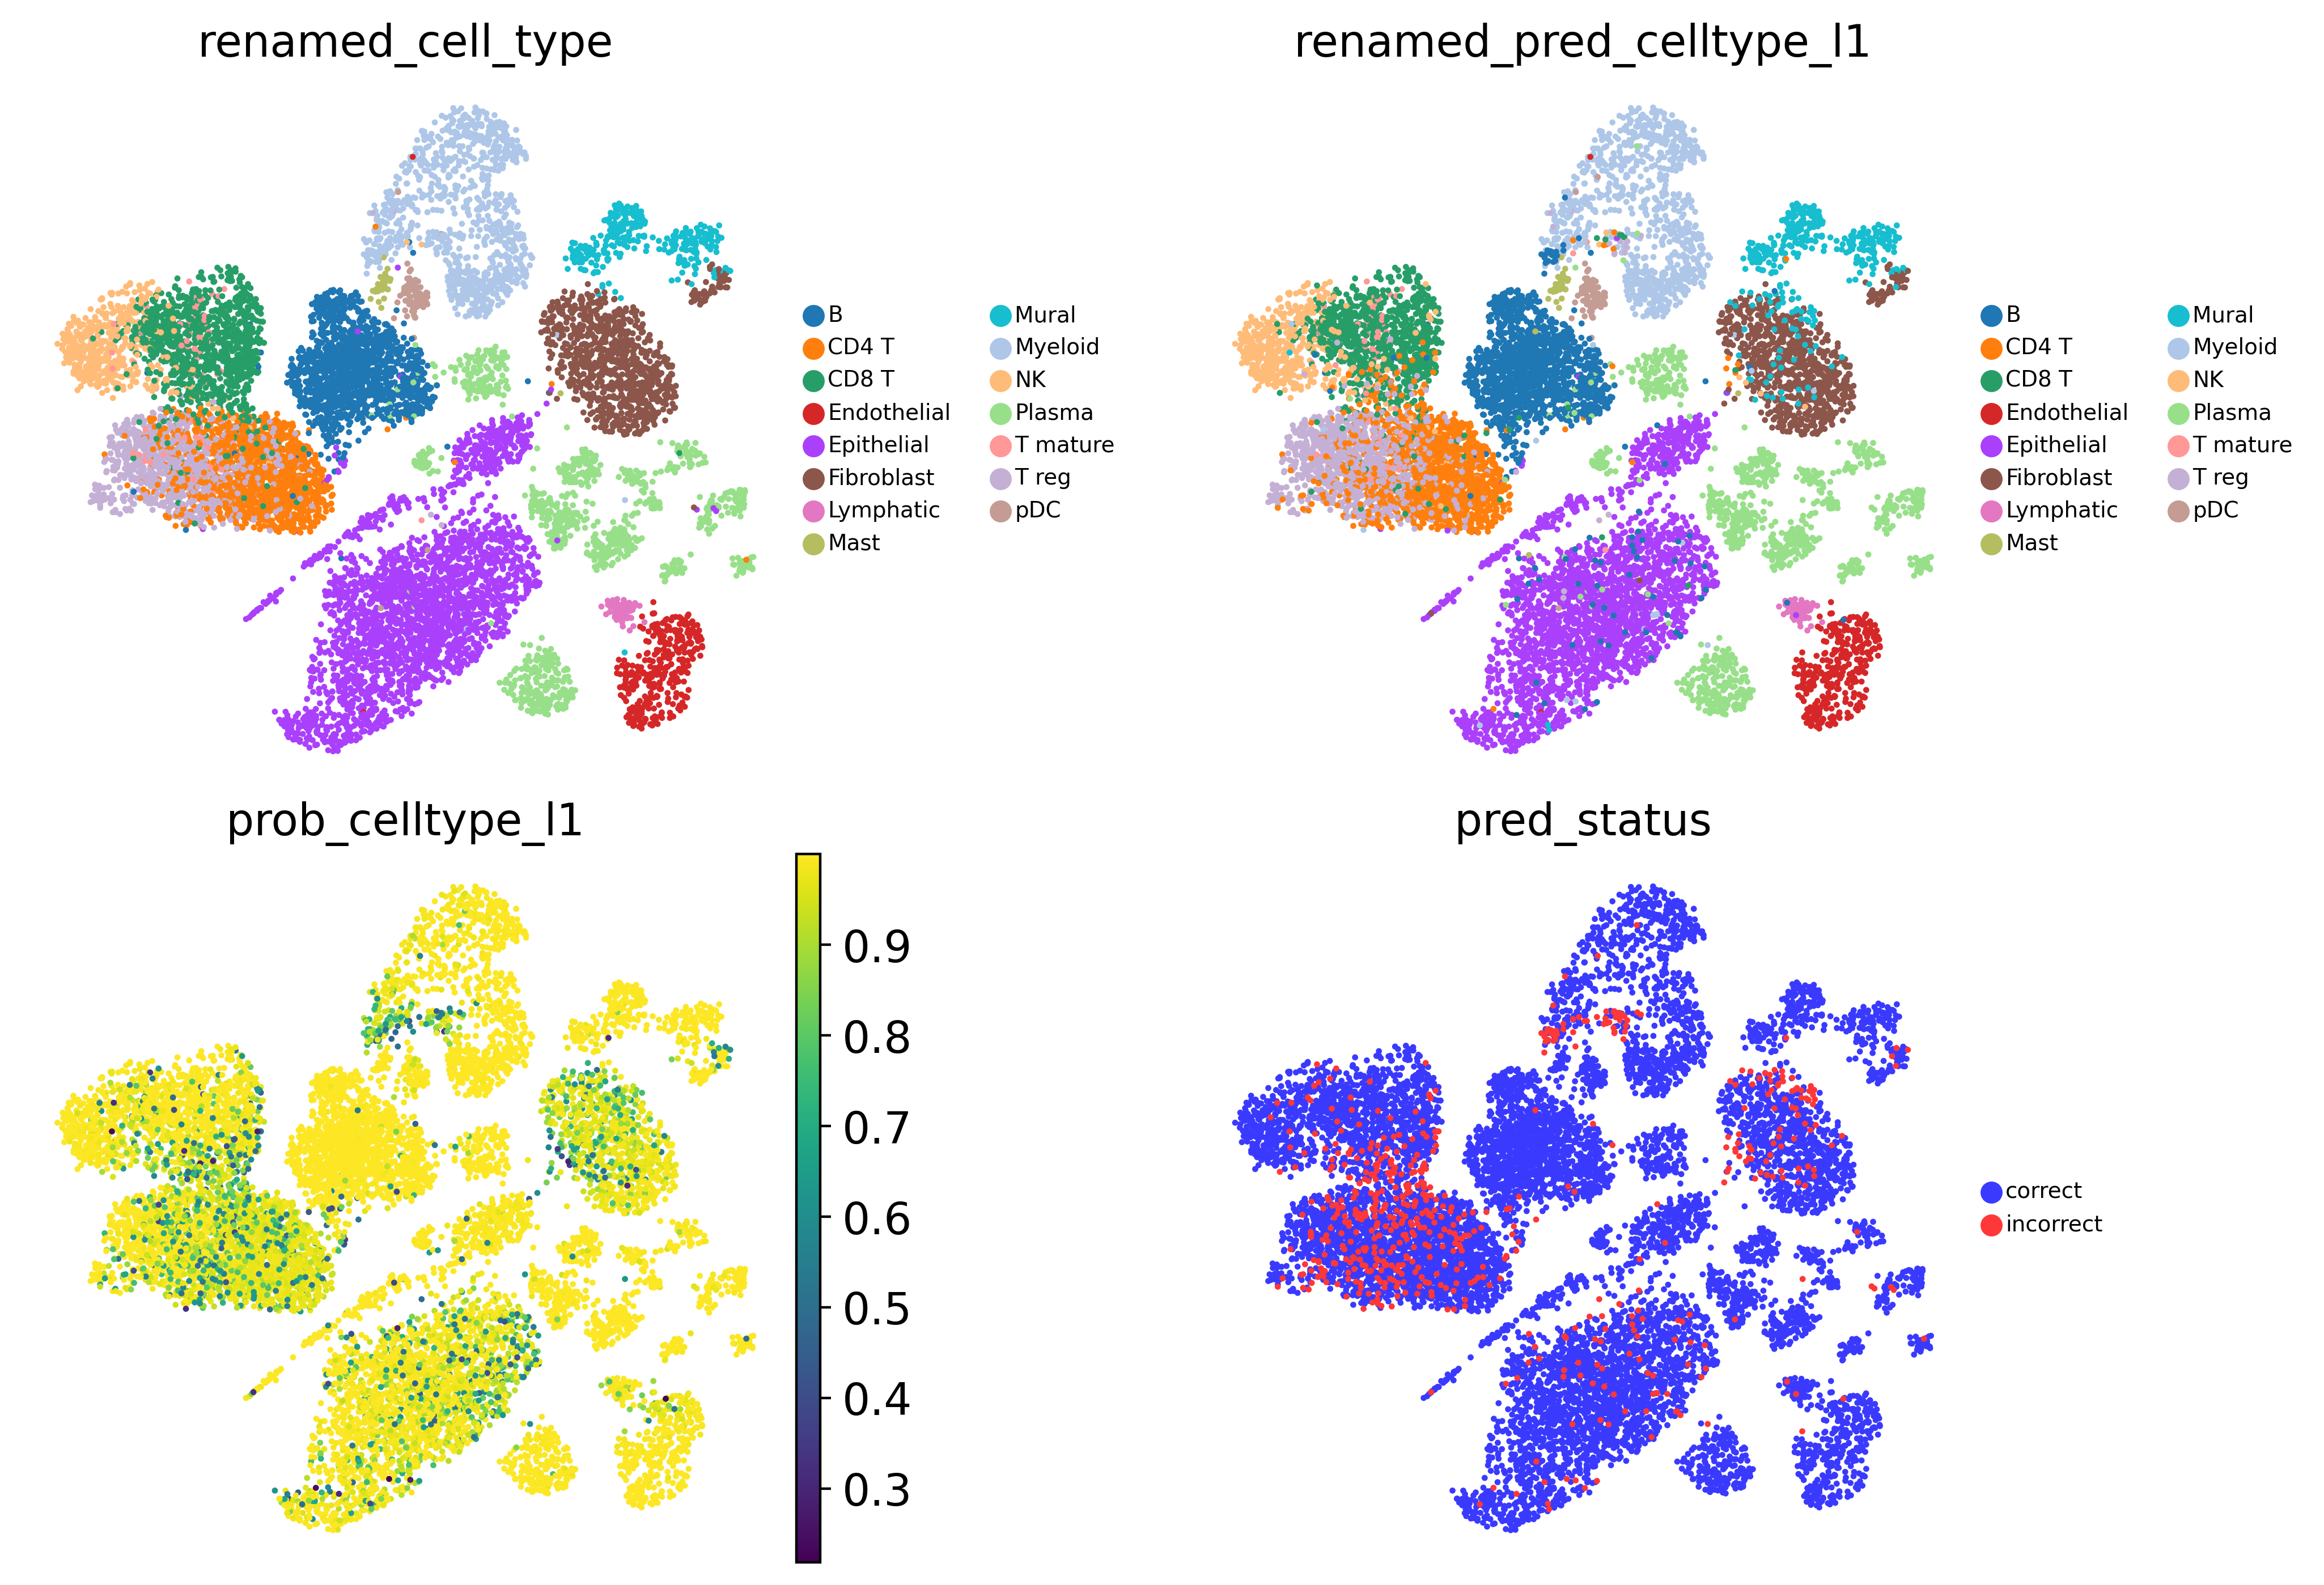

In [62]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
sc.pl.embedding(adata_test_8, 
                color=[
                    'renamed_cell_type',
                    'renamed_pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 15,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_oroph_cancer_scAdam_default.png')

In [33]:
df_default = scparadise.scnoah.report_classif_full(adata_test_1,
                                                       celltype='cell_type',
                                                       pred_celltype='pred_celltype_l1',
                                                       save_report = False)
df_default

precision recall/sensitivity  \
B cell                                   0.9955              0.973   
CD4-positive, alpha-beta T cell          0.9527             0.8792   
CD8-positive, alpha-beta T cell          0.9224             0.8814   
endothelial cell                         0.9834             0.9875   
endothelial cell of lymphatic vessel     0.6000                1.0   
epithelial cell                          0.9872             0.9668   
fibroblast                               0.9510              0.951   
mast cell                                1.0000                1.0   
mature alpha-beta T cell                 0.5600             0.9333   
mural cell                               0.9825             0.9657   
myeloid cell                             0.9921             0.9543   
natural killer cell                      0.8400             0.8936   
plasma cell                              0.9286                1.0   
plasmacytoid dendritic cell              0.9231                1.0   
regulatory T cell                        0.7057             0.9403   
macro avg                                0.8883             0.9551   
weighted avg                             0.9605             0.9554   
Accuracy                                 0.9554                      
Balanced accuracy                        0.9551                      

                                     specificity f1-score geometric mean  \
B cell                                    0.9986   0.9841         0.9857   
CD4-positive, alpha-beta T cell           0.9944   0.9145          0.935   
CD8-positive, alpha-beta T cell           0.9961   0.9014          0.937   
endothelial cell                          0.9996   0.9854         0.9935   
endothelial cell of lymphatic vessel      0.9996     0.75         0.9998   
epithelial cell                           0.9943   0.9769         0.9805   
fibroblast                                0.9989    0.951         0.9747   
mast cell                                    1.0      1.0            1.0   
mature alpha-beta T cell                  0.9977      0.7          0.965   
mural cell                                0.9996    0.974         0.9825   
myeloid cell                              0.9997   0.9728         0.9767   
natural killer cell                       0.9983    0.866         0.9445   
plasma cell                               0.9911    0.963         0.9955   
plasmacytoid dendritic cell               0.9998     0.96         0.9999   
regulatory T cell                         0.9833   0.8062         0.9615   
macro avg                                 0.9967   0.9137         0.9754   
weighted avg                              0.9953   0.9566          0.975   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                0.9692            2297  
CD4-positive, alpha-beta T cell                       0.8642            1076  
CD8-positive, alpha-beta T cell                       0.8678             472  
endothelial cell                                      0.9859             240  
endothelial cell of lymphatic vessel                  0.9996               6  
epithelial cell                                       0.9587            2955  
fibroblast                                            0.9454             204  
mast cell                                                1.0              29  
mature alpha-beta T cell                              0.9252              30  
mural cell                                             0.962             233  
myeloid cell                                          0.9497             394  
natural killer cell                                   0.8827              94  
plasma cell                                            0.992             975  
plasmacyto

## Warm start model training

In [27]:
adata_train_2_balanced = scparadise.scnoah.balance(adata_train_2, 
                                                   sample='donor_id',
                                                   celltype_l1='cell_type')

Successfully undersampled cell types: myeloid cell, B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, epithelial cell

Successfully oversampled cell types: regulatory T cell, plasma cell, fibroblast, plasmacytoid dendritic cell, endothelial cell, natural killer cell, mural cell, mature alpha-beta T cell, mast cell, endothelial cell of lymphatic vessel


In [28]:
adata_train_2_balanced.raw = adata_train_2_balanced

In [40]:
# Warm start requires second training dataset and path to pretrained model 
scparadise.scadam.warm_start(adata_train_2_balanced,
                             path='', # path to save model
                             model_name='model_oropharyngeal_cancer_scadam_default', # folder name with pretrained model
                             celltype_l1='celltype_l1',
                             eval_metric=['accuracy'])

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Train dataset contains: 9625 cells, it is 90.0 % of input dataset
Test dataset contains: 1070 cells, it is 10.0 % of input dataset

Successfully loaded parameters

Accelerator: cuda
Start training
epoch 0  | loss: 0.48133 | train_accuracy: 0.94348 | valid_accuracy: 0.94766 |  0:00:00s
epoch 1  | loss: 0.36669 | train_accuracy: 0.96364 | valid_accuracy: 0.95794 |  0:00:01s
epoch 2  | loss: 0.3216  | train_accuracy: 0.9681  | valid_accuracy: 0.96075 |  0:00:02s
epoch 3  | loss: 0.30067 | train_accuracy: 0.97621 | valid_accuracy: 0.96449 |  0:00:02s
epoch 4  | loss: 0.29271 | train_accuracy: 0.97517 | valid_accuracy: 0.96542 |  0:00:03s
epoch 5  | loss: 0.27386 | train_accuracy: 0.97808 | valid_accuracy: 0.96916 |  0:00:04s
epoch 6  | loss: 0.26328 | train_accuracy: 0.98286 | valid_accuracy: 0.97009 |  0:00:04s
epoch 7  | loss: 0.26985 | train_accuracy: 0.98203 | valid_accurac

### Evaluation of prediction results

In [41]:
# Predict cell types using trained model
for adata_test, j in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Oropharyngeal_cancer/scadam_warm_start', j))
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_oropharyngeal_cancer_scadam_default')
    df_default = scparadise.scnoah.report_classif_full(adata_test,
                                                       celltype='cell_type',
                                                       pred_celltype='pred_celltype_l1',
                                                       report_name='report_test_scadam_warm_start_' + 'cell_type' + '.csv',
                                                       save_path = os.path.join('Oropharyngeal_cancer/scadam_warm_start', j).replace("\\","/"),
                                                       save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [55]:
adata_test_8 = scparadise.scadam.predict(adata_test_8, 
                                         path_model = 'model_oropharyngeal_cancer_scadam_default')
# Order cell type colors
celltype = np.unique(adata_test_8.obs['cell_type']).tolist()
adata_test_8.obs['cell_type'] = pd.Categorical(
    values=adata_test_8.obs['cell_type'], categories=celltype, ordered=True
)
adata_test_8.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test_8.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_8, celltype='cell_type', pred_celltype='pred_celltype_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


In [56]:
cluster_list = adata_test_8.obs['cell_type'].unique()
# Make cluster anottation dictionary
annotation = {"Plasma":['plasma cell'],
              "CD4 T": ['CD4-positive, alpha-beta T cell'],
              'Epithelial':['epithelial cell'],
              "B":['B cell'],
              "NK" :['natural killer cell'],
              "Endothelial":['endothelial cell'],
              "T reg":['regulatory T cell'],
              "pDC":['plasmacytoid dendritic cell'],
              "Myeloid":['myeloid cell'],
              "CD8 T":['CD8-positive, alpha-beta T cell'],
              "Mural ":['mural cell'],
              "Fibroblast":['fibroblast'],
              "Lymphatic":['endothelial cell of lymphatic vessel'],
              "Mast":['mast cell'],
              "T mature":['mature alpha-beta T cell']
             }

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if i in annotation[k]:
            annotation_rev[i] = k

adata_test_8.obs["renamed_cell_type"] = [annotation_rev[i] for i in adata_test_8.obs['cell_type']]
adata_test_8.obs["renamed_pred_celltype_l1"] = [annotation_rev[i] for i in adata_test_8.obs['pred_celltype_l1']]
adata_test_8 = adata_test_8[adata_test_8.obs['pred_status'].sort_values().index,:]

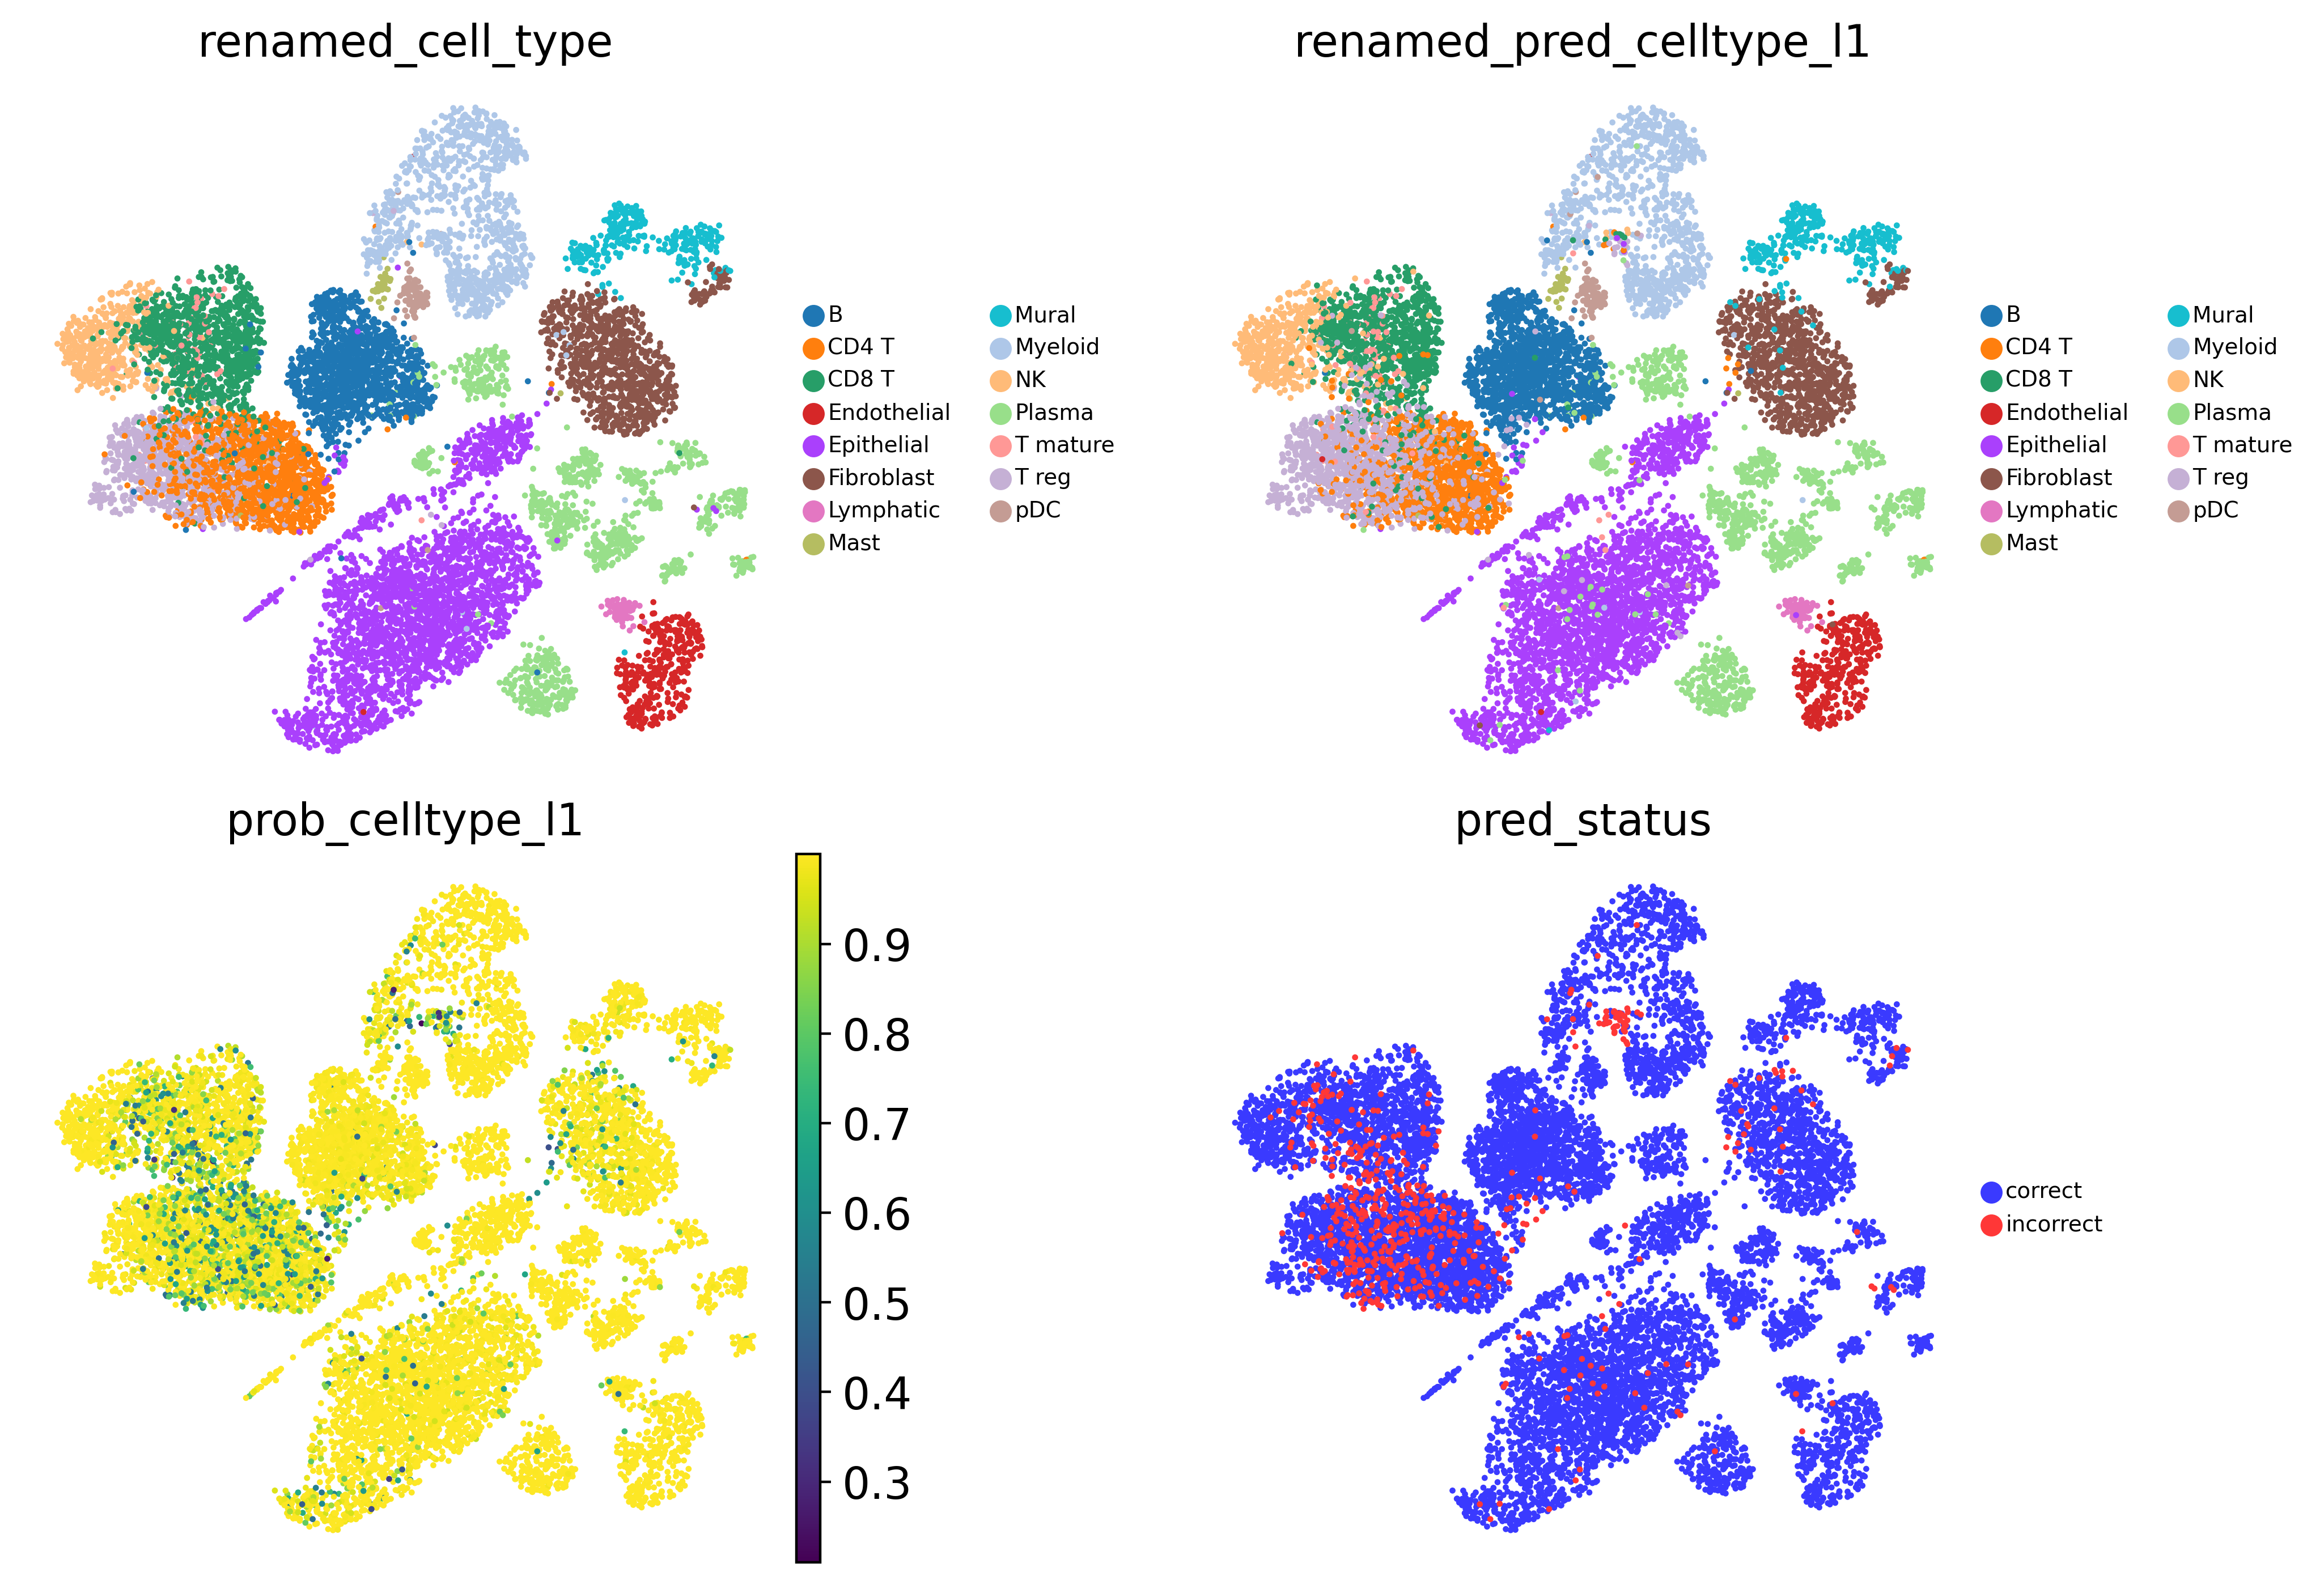

In [58]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
sc.pl.embedding(adata_test_8, 
                color=[
                    'renamed_cell_type',
                    'renamed_pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 15,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_oroph_cancer_scAdam_warm_start.png')

## Hyperparameters tuning

In [108]:
scparadise.scadam.hyperparameter_tuning(adata_train_1_balanced,
                                        path='',
                                        model_name='model_oropharyngeal_cancer_scadam__tuning', # Folder to save hyperparameter tuning results
                                        celltype_l1='celltype_l1',
                                        random_state=1,
                                        num_trials=200, # The number of attempts to find the optimal hyperparameters for the model (recommended - minimum 100)
                                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Accelerator: cuda



[I 2025-05-13 19:02:06,506] A new study created in RDB with name: model_oropharyngeal_cancer_scadam__tuning


Fold 1:

Early stopping occurred at epoch 82 with best_epoch = 72 and best_valid_accuracy = 0.96717

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 69 and best_valid_accuracy = 0.96754

Fold 3:

Early stopping occurred at epoch 94 with best_epoch = 84 and best_valid_accuracy = 0.97233

Fold 4:

Early stopping occurred at epoch 84 with best_epoch = 74 and best_valid_accuracy = 0.97087


[I 2025-05-13 19:04:40,103] Trial 0 finished with value: 0.9694788943003976 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.3, 'momentum': 0.02, 'lr': 0.01, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'patience': 10, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 0 with value: 0.9694788943003976.



Fold 1:

Early stopping occurred at epoch 16 with best_epoch = 11 and best_valid_accuracy = 0.96902

Fold 2:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.97233

Fold 3:

Early stopping occurred at epoch 29 with best_epoch = 24 and best_valid_accuracy = 0.97455

Fold 4:

Early stopping occurred at epoch 33 with best_epoch = 28 and best_valid_accuracy = 0.97493


[I 2025-05-13 19:05:20,626] Trial 1 finished with value: 0.9727061115590476 and parameters: {'n_d': 56, 'n_a': 96, 'n_steps': 1, 'n_shared': 4, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.1862602113776708, 'momentum': 0.14476868354678862, 'lr': 0.1984440603679119, 'mask_type': 'entmax', 'lambda_sparse': 0.007069470359901731, 'patience': 5, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 1 with value: 0.9727061115590476.



Fold 1:

Early stopping occurred at epoch 11 with best_epoch = 1 and best_valid_accuracy = 0.07562


[I 2025-05-13 19:05:34,635] Trial 2 pruned. 


Fold 1:

Early stopping occurred at epoch 7 with best_epoch = 2 and best_valid_accuracy = 0.1221

Fold 2:

Early stopping occurred at epoch 8 with best_epoch = 3 and best_valid_accuracy = 0.10992

Fold 3:

Early stopping occurred at epoch 8 with best_epoch = 3 and best_valid_accuracy = 0.11546

Fold 4:

Early stopping occurred at epoch 17 with best_epoch = 12 and best_valid_accuracy = 0.10509


[I 2025-05-13 19:06:21,903] Trial 3 finished with value: 0.11314043816898053 and parameters: {'n_d': 8, 'n_a': 100, 'n_steps': 10, 'n_shared': 8, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.103226006577642, 'momentum': 0.18467847520860303, 'lr': 0.45430689199623847, 'mask_type': 'entmax', 'lambda_sparse': 0.00022435885546638436, 'patience': 5, 'max_epochs': 70, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 1 with value: 0.9727061115590476.



Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 49 and best_valid_accuracy = 0.97529

Fold 2:

Early stopping occurred at epoch 89 with best_epoch = 74 and best_valid_accuracy = 0.97418

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 88 and best_valid_accuracy = 0.96791

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 50 and best_valid_accuracy = 0.89602


[I 2025-05-13 19:10:39,878] Trial 4 finished with value: 0.9533478404925199 and parameters: {'n_d': 24, 'n_a': 80, 'n_steps': 7, 'n_shared': 2, 'cat_emb_dim': 5, 'n_independent': 7, 'gamma': 1.4141792695269026, 'momentum': 0.02948184898897399, 'lr': 0.26799461331716423, 'mask_type': 'entmax', 'lambda_sparse': 0.03543503880316684, 'patience': 15, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 1024}. Best is trial 1 with value: 0.9727061115590476.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 63 and best_valid_accuracy = 0.93102


[I 2025-05-13 19:12:06,827] Trial 5 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 53 and best_valid_accuracy = 0.97824

Fold 2:
Stop training because you reached max_epochs = 70 with best_epoch = 62 and best_valid_accuracy = 0.97824

Fold 3:
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_accuracy = 0.97934

Fold 4:
Stop training because you reached max_epochs = 70 with best_epoch = 52 and best_valid_accuracy = 0.97603


[I 2025-05-13 19:15:41,926] Trial 6 finished with value: 0.9779623725149043 and parameters: {'n_d': 36, 'n_a': 120, 'n_steps': 6, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 4, 'gamma': 1.5270581022576093, 'momentum': 0.3555174187312021, 'lr': 0.17869915302524964, 'mask_type': 'entmax', 'lambda_sparse': 0.00011033189053588348, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 6 with value: 0.9779623725149043.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.81003

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 81 and best_valid_accuracy = 0.81372

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.79048


[I 2025-05-13 19:17:42,837] Trial 7 pruned. 


Fold 1:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.63371

Fold 2:
Stop training because you reached max_epochs = 25 with best_epoch = 24 and best_valid_accuracy = 0.96016

Fold 3:
Stop training because you reached max_epochs = 25 with best_epoch = 24 and best_valid_accuracy = 0.85024


[I 2025-05-13 19:18:52,029] Trial 8 pruned. 


Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.45998

Fold 2:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.51715

Fold 3:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.58797


[I 2025-05-13 19:19:01,582] Trial 9 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_valid_accuracy = 0.95647

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_accuracy = 0.96422

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_valid_accuracy = 0.9727

Fold 4:
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_valid_accuracy = 0.97271


[I 2025-05-13 19:22:05,264] Trial 10 finished with value: 0.9665277836716796 and parameters: {'n_d': 60, 'n_a': 128, 'n_steps': 6, 'n_shared': 1, 'cat_emb_dim': 10, 'n_independent': 4, 'gamma': 1.55009186676258, 'momentum': 0.3974222436462944, 'lr': 0.3245633221398093, 'mask_type': 'entmax', 'lambda_sparse': 0.0007812191535536396, 'patience': 20, 'max_epochs': 40, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 6 with value: 0.9779623725149043.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 68 and best_valid_accuracy = 0.97971

Fold 2:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.97713

Fold 4:
Stop training because you reached max_epochs = 75 with best_epoch = 70 and best_valid_accuracy = 0.98304


[I 2025-05-13 19:24:28,307] Trial 11 finished with value: 0.979713847441158 and parameters: {'n_d': 56, 'n_a': 124, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 6, 'n_independent': 4, 'gamma': 1.2436410483269538, 'momentum': 0.2911770770893238, 'lr': 0.2006491451466231, 'mask_type': 'entmax', 'lambda_sparse': 0.006812189344389553, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 256, 'batch_size': 512}. Best is trial 11 with value: 0.979713847441158.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 59 and best_valid_accuracy = 0.51125

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 64 and best_valid_accuracy = 0.70527

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.49723


[I 2025-05-13 19:25:21,846] Trial 12 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 38 and best_valid_accuracy = 0.98193

Fold 2:

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.97492

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_valid_accuracy = 0.97602


[I 2025-05-13 19:27:05,173] Trial 13 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.97602


[I 2025-05-13 19:28:15,005] Trial 14 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_valid_accuracy = 0.98008

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 36 and best_valid_accuracy = 0.97676

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.97381

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_valid_accuracy = 0.97677


[I 2025-05-13 19:34:13,542] Trial 15 finished with value: 0.9768557017787252 and parameters: {'n_d': 44, 'n_a': 56, 'n_steps': 4, 'n_shared': 3, 'cat_emb_dim': 5, 'n_independent': 5, 'gamma': 1.1949597902260523, 'momentum': 0.27557442503093443, 'lr': 0.14865278285803288, 'mask_type': 'entmax', 'lambda_sparse': 0.002823261391960469, 'patience': 15, 'max_epochs': 50, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 11 with value: 0.979713847441158.



Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_valid_accuracy = 0.94098


[I 2025-05-13 19:34:43,284] Trial 16 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 77 and best_valid_accuracy = 0.80819

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.66986

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 77 and best_valid_accuracy = 0.72003


[I 2025-05-13 19:35:35,114] Trial 17 pruned. 


Fold 1:

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_accuracy = 0.42752


[I 2025-05-13 19:36:38,276] Trial 18 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 74 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 41 and best_valid_accuracy = 0.97934

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 36 and best_valid_accuracy = 0.97934

Fold 4:

Early stopping occurred at epoch 74 with best_epoch = 59 and best_valid_accuracy = 0.97714


[I 2025-05-13 19:39:05,972] Trial 19 finished with value: 0.9797143914936307 and parameters: {'n_d': 32, 'n_a': 60, 'n_steps': 4, 'n_shared': 3, 'cat_emb_dim': 10, 'n_independent': 3, 'gamma': 1.4759582260119952, 'momentum': 0.22816812024736557, 'lr': 0.0806264200740974, 'mask_type': 'entmax', 'lambda_sparse': 0.00038384259381445905, 'patience': 15, 'max_epochs': 80, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 19 with value: 0.9797143914936307.



Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 61 and best_valid_accuracy = 0.98266

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 45 and best_valid_accuracy = 0.98045

Fold 3:

Early stopping occurred at epoch 71 with best_epoch = 56 and best_valid_accuracy = 0.97639

Fold 4:

Early stopping occurred at epoch 48 with best_epoch = 33 and best_valid_accuracy = 0.97898


[I 2025-05-13 19:40:44,659] Trial 20 finished with value: 0.979622004583098 and parameters: {'n_d': 56, 'n_a': 56, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.4181202652370541, 'momentum': 0.1943831328835654, 'lr': 0.08285083899326177, 'mask_type': 'entmax', 'lambda_sparse': 0.00036523116626910204, 'patience': 15, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1536}. Best is trial 19 with value: 0.9797143914936307.



Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 64 and best_valid_accuracy = 0.98193

Fold 2:

Early stopping occurred at epoch 44 with best_epoch = 29 and best_valid_accuracy = 0.97676

Fold 3:

Early stopping occurred at epoch 83 with best_epoch = 68 and best_valid_accuracy = 0.98082

Fold 4:

Early stopping occurred at epoch 79 with best_epoch = 64 and best_valid_accuracy = 0.98119


[I 2025-05-13 19:42:23,105] Trial 21 finished with value: 0.9801751019282309 and parameters: {'n_d': 60, 'n_a': 56, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.4356849481930465, 'momentum': 0.19758931100752783, 'lr': 0.07852119418339541, 'mask_type': 'entmax', 'lambda_sparse': 0.0003748264930775236, 'patience': 15, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1792}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 41 and best_valid_accuracy = 0.97934

Fold 2:

Early stopping occurred at epoch 75 with best_epoch = 60 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.98008

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 35 and best_valid_accuracy = 0.97566


[I 2025-05-13 19:43:47,520] Trial 22 finished with value: 0.9790690092478038 and parameters: {'n_d': 64, 'n_a': 28, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.4438688227512628, 'momentum': 0.2356470200841562, 'lr': 0.08382737754527696, 'mask_type': 'entmax', 'lambda_sparse': 0.0013786881295284816, 'patience': 15, 'max_epochs': 80, 'virtual_batch_size': 256, 'batch_size': 1792}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 53 and best_valid_accuracy = 0.97639


[I 2025-05-13 19:44:18,606] Trial 23 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.97897

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98156

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 52 and best_valid_accuracy = 0.97381

Fold 4:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.97677


[I 2025-05-13 19:45:18,175] Trial 24 finished with value: 0.9777778707200753 and parameters: {'n_d': 48, 'n_a': 72, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 10, 'n_independent': 2, 'gamma': 1.305161812692475, 'momentum': 0.22078541268048235, 'lr': 0.11242485340919359, 'mask_type': 'entmax', 'lambda_sparse': 0.006165971633281117, 'patience': 15, 'max_epochs': 60, 'virtual_batch_size': 256, 'batch_size': 2048}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 60 and best_valid_accuracy = 0.98045

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 49 and best_valid_accuracy = 0.97861

Fold 3:

Early stopping occurred at epoch 49 with best_epoch = 34 and best_valid_accuracy = 0.97049


[I 2025-05-13 19:46:59,717] Trial 25 pruned. 


Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 39 and best_valid_accuracy = 0.97824

Fold 2:

Early stopping occurred at epoch 52 with best_epoch = 42 and best_valid_accuracy = 0.97602

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.98193

Fold 4:

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.97271


[I 2025-05-13 19:48:20,047] Trial 26 finished with value: 0.9772249433913401 and parameters: {'n_d': 80, 'n_a': 36, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.4627269205371753, 'momentum': 0.25527136290272856, 'lr': 0.043766971705916605, 'mask_type': 'entmax', 'lambda_sparse': 0.0002984481911782962, 'patience': 10, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1792}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 54 and best_valid_accuracy = 0.98008

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 27 and best_valid_accuracy = 0.97455

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 42 and best_valid_accuracy = 0.97861

Fold 4:

Early stopping occurred at epoch 39 with best_epoch = 24 and best_valid_accuracy = 0.97198


[I 2025-05-13 19:50:32,272] Trial 27 finished with value: 0.9763028424565493 and parameters: {'n_d': 52, 'n_a': 20, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 10, 'n_independent': 5, 'gamma': 1.35406146466973, 'momentum': 0.11676073503256829, 'lr': 0.10350247823229351, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004925787521326779, 'patience': 15, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.97971

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 72 and best_valid_accuracy = 0.97824

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.9727


[I 2025-05-13 19:51:37,322] Trial 28 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.6706

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_accuracy = 0.68572

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_accuracy = 0.70122


[I 2025-05-13 19:54:05,600] Trial 29 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.9561


[I 2025-05-13 19:54:21,554] Trial 30 pruned. 


Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 68 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 43 with best_epoch = 28 and best_valid_accuracy = 0.97492

Fold 3:

Early stopping occurred at epoch 66 with best_epoch = 51 and best_valid_accuracy = 0.97861


[I 2025-05-13 19:55:35,319] Trial 31 pruned. 


Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 48 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 73 with best_epoch = 58 and best_valid_accuracy = 0.98008

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 57 and best_valid_accuracy = 0.97861


[I 2025-05-13 19:57:15,961] Trial 32 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 45 and best_valid_accuracy = 0.97824

Fold 2:

Early stopping occurred at epoch 83 with best_epoch = 68 and best_valid_accuracy = 0.98045

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 53 and best_valid_accuracy = 0.97602

Fold 4:

Early stopping occurred at epoch 81 with best_epoch = 66 and best_valid_accuracy = 0.97677


[I 2025-05-13 19:58:55,531] Trial 33 finished with value: 0.9778700876142102 and parameters: {'n_d': 68, 'n_a': 72, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 10, 'n_independent': 4, 'gamma': 1.306489831068403, 'momentum': 0.19339922965843503, 'lr': 0.15596290937343285, 'mask_type': 'entmax', 'lambda_sparse': 0.009187516073159355, 'patience': 15, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1536}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 51 and best_valid_accuracy = 0.9775

Fold 2:

Early stopping occurred at epoch 68 with best_epoch = 58 and best_valid_accuracy = 0.97713

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 62 and best_valid_accuracy = 0.97602

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 56 and best_valid_accuracy = 0.97603


[I 2025-05-13 20:00:17,267] Trial 34 finished with value: 0.9766713359970143 and parameters: {'n_d': 52, 'n_a': 92, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.5605616737402115, 'momentum': 0.12399178676247175, 'lr': 0.10398811847817382, 'mask_type': 'entmax', 'lambda_sparse': 0.0003694014721811844, 'patience': 10, 'max_epochs': 80, 'virtual_batch_size': 256, 'batch_size': 2048}. Best is trial 21 with value: 0.9801751019282309.



Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_accuracy = 0.98303

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.97934

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.98304



[I 2025-05-13 20:02:44,017] Trial 35 finished with value: 0.9818348360062631 and parameters: {'n_d': 36, 'n_a': 64, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 8, 'n_independent': 10, 'gamma': 1.1677264906489495, 'momentum': 0.20347677879132303, 'lr': 0.029272158546913424, 'mask_type': 'entmax', 'lambda_sparse': 0.00017628148267598336, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1792}. Best is trial 35 with value: 0.9818348360062631.


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_valid_accuracy = 0.97861


[I 2025-05-13 20:03:07,009] Trial 36 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_valid_accuracy = 0.80081


[I 2025-05-13 20:03:39,665] Trial 37 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_accuracy = 0.97934

Fold 2:
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_accuracy = 0.97713

Fold 3:
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_accuracy = 0.97233


[I 2025-05-13 20:04:38,829] Trial 38 pruned. 


Fold 1:

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.98377

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.98119

Fold 4:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.97529


[I 2025-05-13 20:08:29,572] Trial 39 finished with value: 0.9798067784041634 and parameters: {'n_d': 40, 'n_a': 92, 'n_steps': 3, 'n_shared': 5, 'cat_emb_dim': 7, 'n_independent': 8, 'gamma': 1.058486488541964, 'momentum': 0.3161945701946107, 'lr': 0.057088604204429266, 'mask_type': 'entmax', 'lambda_sparse': 0.029262531070527235, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_accuracy = 0.98008

Fold 2:
Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.98008

Fold 4:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.97935


[I 2025-05-13 20:12:03,924] Trial 40 finished with value: 0.9803597057328985 and parameters: {'n_d': 40, 'n_a': 88, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 7, 'n_independent': 9, 'gamma': 1.824929487299558, 'momentum': 0.0703394381263295, 'lr': 0.05692153253393062, 'mask_type': 'sparsemax', 'lambda_sparse': 0.033149583795942114, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.97565


[I 2025-05-13 20:12:40,236] Trial 41 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.97713

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.97713

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.98156

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.97714


[I 2025-05-13 20:16:49,690] Trial 42 finished with value: 0.9782389211874707 and parameters: {'n_d': 24, 'n_a': 80, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 9, 'gamma': 1.826270375955703, 'momentum': 0.06401442507808972, 'lr': 0.02759872692345868, 'mask_type': 'sparsemax', 'lambda_sparse': 0.04481535504303663, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.98266

Fold 2:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.98266

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_valid_accuracy = 0.98045

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 78 and best_valid_accuracy = 0.97714


[I 2025-05-13 20:20:16,146] Trial 43 finished with value: 0.9807287773291159 and parameters: {'n_d': 40, 'n_a': 68, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 7, 'n_independent': 8, 'gamma': 1.8456691190507155, 'momentum': 0.32036562524927786, 'lr': 0.06883478038064071, 'mask_type': 'sparsemax', 'lambda_sparse': 0.029239066020094667, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.89561

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_accuracy = 0.92032

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.89709


[I 2025-05-13 20:22:57,989] Trial 44 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 84 and best_valid_accuracy = 0.86721


[I 2025-05-13 20:23:30,091] Trial 45 pruned. 


Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.97492


[I 2025-05-13 20:23:56,250] Trial 46 pruned. 


Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.3792


[I 2025-05-13 20:24:00,399] Trial 47 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.97086


[I 2025-05-13 20:26:38,904] Trial 48 pruned. 


Fold 1:

Early stopping occurred at epoch 26 with best_epoch = 21 and best_valid_accuracy = 0.97123


[I 2025-05-13 20:26:50,697] Trial 49 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 85 and best_valid_accuracy = 0.98266

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 75 and best_valid_accuracy = 0.98193

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.97381


[I 2025-05-13 20:34:42,123] Trial 50 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 86 and best_valid_accuracy = 0.98156

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 76 and best_valid_accuracy = 0.97639

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.97418


[I 2025-05-13 20:37:56,387] Trial 51 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 40 and best_valid_accuracy = 0.97713


[I 2025-05-13 20:38:31,893] Trial 52 pruned. 


Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98082

Fold 3:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.98193

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 92 and best_valid_accuracy = 0.98304


[I 2025-05-13 20:41:38,736] Trial 53 finished with value: 0.9818348360062631 and parameters: {'n_d': 40, 'n_a': 68, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 4, 'n_independent': 7, 'gamma': 1.9298117370451175, 'momentum': 0.27239326035251243, 'lr': 0.037775791855098856, 'mask_type': 'entmax', 'lambda_sparse': 0.00013783450505897076, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.98045

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 99 with best_epoch = 79 and best_valid_accuracy = 0.97934


[I 2025-05-13 20:43:15,622] Trial 54 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.95315

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 91 and best_valid_accuracy = 0.96201

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.96274


[I 2025-05-13 20:44:31,983] Trial 55 pruned. 


Fold 1:
Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_valid_accuracy = 0.95574


[I 2025-05-13 20:44:42,680] Trial 56 pruned. 


Fold 1:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.9834

Fold 2:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.97971

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 71 and best_valid_accuracy = 0.98008

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.98046


[I 2025-05-13 20:47:26,164] Trial 57 finished with value: 0.9809129050878699 and parameters: {'n_d': 24, 'n_a': 84, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 4, 'n_independent': 8, 'gamma': 1.778748920727332, 'momentum': 0.3292261668382054, 'lr': 0.13695664113428507, 'mask_type': 'entmax', 'lambda_sparse': 0.0001981414933338179, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.96938

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 80 and best_valid_accuracy = 0.95721

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 87 and best_valid_accuracy = 0.9443


[I 2025-05-13 20:49:17,188] Trial 58 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 75 and best_valid_accuracy = 0.98082

Fold 2:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.97676

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.97197


[I 2025-05-13 20:51:47,232] Trial 59 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_valid_accuracy = 0.97565

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_valid_accuracy = 0.96865

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_valid_accuracy = 0.97418


[I 2025-05-13 20:52:54,769] Trial 60 pruned. 


Fold 1:

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.97861

Fold 3:

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_accuracy = 0.98119

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_accuracy = 0.97972


[I 2025-05-13 20:55:45,484] Trial 61 finished with value: 0.9802674548354839 and parameters: {'n_d': 40, 'n_a': 88, 'n_steps': 3, 'n_shared': 3, 'cat_emb_dim': 4, 'n_independent': 8, 'gamma': 1.7791785921260022, 'momentum': 0.3276872650969611, 'lr': 0.05824878064954056, 'mask_type': 'entmax', 'lambda_sparse': 0.00020041792019925476, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.98229

Fold 2:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.98082

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 72 and best_valid_accuracy = 0.97787


[I 2025-05-13 20:57:22,480] Trial 62 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.97824

Fold 2:
Stop training because you reached max_epochs = 95 with best_epoch = 84 and best_valid_accuracy = 0.96975

Fold 3:
Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_valid_accuracy = 0.97307


[I 2025-05-13 20:59:05,070] Trial 63 pruned. 


Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.97934

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.97934

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_valid_accuracy = 0.97787


[I 2025-05-13 21:01:23,335] Trial 64 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 67 and best_valid_accuracy = 0.98193

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.97824

Fold 3:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.97713


[I 2025-05-13 21:02:47,049] Trial 65 pruned. 


Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 92 with best_epoch = 72 and best_valid_accuracy = 0.98119

Fold 3:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.98045

Fold 4:
Stop training because you reached max_epochs = 95 with best_epoch = 81 and best_valid_accuracy = 0.98083


[I 2025-05-13 21:07:36,297] Trial 66 finished with value: 0.9813739555552654 and parameters: {'n_d': 44, 'n_a': 100, 'n_steps': 3, 'n_shared': 3, 'cat_emb_dim': 4, 'n_independent': 9, 'gamma': 1.662516926451035, 'momentum': 0.3491869594903048, 'lr': 0.021341664113181225, 'mask_type': 'entmax', 'lambda_sparse': 0.00031155751400581443, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 83 and best_valid_accuracy = 0.9775


[I 2025-05-13 21:09:00,620] Trial 67 pruned. 


Fold 1:

Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.98008

Fold 2:

Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.98008

Fold 3:
Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_accuracy = 0.97934

Fold 4:
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.97751


[I 2025-05-13 21:15:34,539] Trial 68 finished with value: 0.9792532730196761 and parameters: {'n_d': 44, 'n_a': 96, 'n_steps': 3, 'n_shared': 9, 'cat_emb_dim': 4, 'n_independent': 8, 'gamma': 1.7337090191037514, 'momentum': 0.3418274894749779, 'lr': 0.018207718831491422, 'mask_type': 'entmax', 'lambda_sparse': 0.0003131031191849865, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.97565


[I 2025-05-13 21:21:49,460] Trial 69 pruned. 


Fold 1:

Early stopping occurred at epoch 39 with best_epoch = 34 and best_valid_accuracy = 0.9775

Fold 2:

Early stopping occurred at epoch 25 with best_epoch = 20 and best_valid_accuracy = 0.96754

Fold 3:

Early stopping occurred at epoch 24 with best_epoch = 19 and best_valid_accuracy = 0.96274


[I 2025-05-13 21:23:01,900] Trial 70 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 85 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.97824

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 85 and best_valid_accuracy = 0.97824

Fold 4:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.98009


[I 2025-05-13 21:25:02,005] Trial 71 finished with value: 0.9795296856791244 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 5, 'n_independent': 7, 'gamma': 1.9121357312905192, 'momentum': 0.3995419261812475, 'lr': 0.07786365979961765, 'mask_type': 'entmax', 'lambda_sparse': 0.004092554589503238, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98008

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.98083


[I 2025-05-13 21:27:57,305] Trial 72 finished with value: 0.9815583893435353 and parameters: {'n_d': 52, 'n_a': 48, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.8626113483373012, 'momentum': 0.292245853636578, 'lr': 0.09429558823299679, 'mask_type': 'entmax', 'lambda_sparse': 0.0005679955564234746, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 72 and best_valid_accuracy = 0.98193

Fold 2:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.97787

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 68 and best_valid_accuracy = 0.97971

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.9764


[I 2025-05-13 21:31:02,591] Trial 73 finished with value: 0.9789767243471099 and parameters: {'n_d': 40, 'n_a': 28, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.949067907673122, 'momentum': 0.33400072640835626, 'lr': 0.11408547732120629, 'mask_type': 'entmax', 'lambda_sparse': 0.0006572153125557068, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98229

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.98266

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.97934

Fold 4:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.98156


[I 2025-05-13 21:33:34,877] Trial 74 finished with value: 0.9814661044428413 and parameters: {'n_d': 44, 'n_a': 84, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 2, 'n_independent': 9, 'gamma': 1.8456711229060552, 'momentum': 0.2905608076302458, 'lr': 0.09501279266598706, 'mask_type': 'entmax', 'lambda_sparse': 0.00046034750064976205, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 35 with value: 0.9818348360062631.



Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.97676


[I 2025-05-13 21:34:09,788] Trial 75 pruned. 


Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.98082

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.97713


[I 2025-05-13 21:35:45,638] Trial 76 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.98082

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.9775


[I 2025-05-13 21:37:39,920] Trial 77 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.97861


[I 2025-05-13 21:38:11,857] Trial 78 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 67 and best_valid_accuracy = 0.98119


[I 2025-05-13 21:39:02,963] Trial 79 pruned. 


Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.98266

Fold 3:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98229

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.98451


[I 2025-05-13 21:41:48,715] Trial 80 finished with value: 0.983310170299305 and parameters: {'n_d': 52, 'n_a': 96, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.9566378187297373, 'momentum': 0.03133104176415543, 'lr': 0.016555539126817148, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00040006870394202794, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 80 with value: 0.983310170299305.



Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.98156

Fold 4:

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_accuracy = 0.98046


[I 2025-05-13 21:44:32,635] Trial 81 finished with value: 0.9811895557702749 and parameters: {'n_d': 52, 'n_a': 96, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.9403225206318233, 'momentum': 0.03421344448549138, 'lr': 0.011279186362705432, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004407073764731704, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 80 with value: 0.983310170299305.



Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.98488

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98008

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.98414

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 79 and best_valid_accuracy = 0.98378


[I 2025-05-13 21:47:13,697] Trial 82 finished with value: 0.9832180214117292 and parameters: {'n_d': 64, 'n_a': 116, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.9528230389759984, 'momentum': 0.05430534315022101, 'lr': 0.012360291139782542, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00041588731120392665, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 80 with value: 0.983310170299305.



Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.98635

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.98229

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 82 and best_valid_accuracy = 0.98266

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.98009


[I 2025-05-13 21:49:37,588] Trial 83 finished with value: 0.9828494938679846 and parameters: {'n_d': 72, 'n_a': 116, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.9541256875465256, 'momentum': 0.03530747046437384, 'lr': 0.016769717793046056, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00040148821543303526, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 80 with value: 0.983310170299305.



Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.98377

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 65 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98229

Fold 4:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98414


[I 2025-05-13 21:51:59,945] Trial 84 finished with value: 0.9829413367260446 and parameters: {'n_d': 72, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.951991239640098, 'momentum': 0.03207928896150583, 'lr': 0.015599206594415714, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004217017317248915, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 80 with value: 0.983310170299305.



Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_accuracy = 0.96533


[I 2025-05-13 21:52:35,621] Trial 85 pruned. 


Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.98156

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.97934

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.97934

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 61 and best_valid_accuracy = 0.98267


[I 2025-05-13 21:54:35,943] Trial 86 finished with value: 0.9807282672799226 and parameters: {'n_d': 72, 'n_a': 124, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 1, 'n_independent': 7, 'gamma': 1.9585371262466076, 'momentum': 0.02184327704745289, 'lr': 0.025323639627331418, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000577904941530178, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 80 with value: 0.983310170299305.



Fold 1:

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.98525

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.9834

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 70 and best_valid_accuracy = 0.98193

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 77 and best_valid_accuracy = 0.98267


[I 2025-05-13 21:57:21,719] Trial 87 finished with value: 0.9833103403157027 and parameters: {'n_d': 64, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.9905537644701652, 'momentum': 0.03945701724184461, 'lr': 0.01340149151207792, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000404242220730831, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 57 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.98045

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 64 and best_valid_accuracy = 0.98045

Fold 4:
Stop training because you reached max_epochs = 75 with best_epoch = 64 and best_valid_accuracy = 0.98304


[I 2025-05-13 21:59:29,265] Trial 88 finished with value: 0.981742619112128 and parameters: {'n_d': 64, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.9258660318252556, 'momentum': 0.06633712318629961, 'lr': 0.04575668198094008, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004129750770642793, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 67 and best_valid_accuracy = 0.98414

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 66 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.98119

Fold 4:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.98083


[I 2025-05-13 22:01:46,940] Trial 89 finished with value: 0.9820194738142105 and parameters: {'n_d': 64, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 1, 'n_independent': 6, 'gamma': 1.988342108381437, 'momentum': 0.03252623627585034, 'lr': 0.03532995985737118, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00039946043531169167, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 43 and best_valid_accuracy = 0.98525

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 53 and best_valid_accuracy = 0.97971

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 51 and best_valid_accuracy = 0.98229

Fold 4:
Stop training because you reached max_epochs = 60 with best_epoch = 43 and best_valid_accuracy = 0.98046


[I 2025-05-13 22:03:34,427] Trial 90 finished with value: 0.981927290923355 and parameters: {'n_d': 64, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 1, 'n_independent': 5, 'gamma': 1.9933747793524967, 'momentum': 0.033045326750970876, 'lr': 0.0466924921178946, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0003892742224811019, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98414

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.98119

Fold 3:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.98045


[I 2025-05-13 22:05:06,038] Trial 91 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 64 and best_valid_accuracy = 0.92512


[I 2025-05-13 22:05:37,216] Trial 92 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98303

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98193

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_accuracy = 0.98193

Fold 4:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98267


[I 2025-05-13 22:07:36,638] Trial 93 finished with value: 0.9823881713743526 and parameters: {'n_d': 80, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 1, 'n_independent': 5, 'gamma': 1.927523476663542, 'momentum': 0.04258618796369813, 'lr': 0.03239609831848046, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0003792462981942572, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 29 and best_valid_accuracy = 0.98045

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 37 and best_valid_accuracy = 0.98082

Fold 3:

Early stopping occurred at epoch 39 with best_epoch = 19 and best_valid_accuracy = 0.97824


[I 2025-05-13 22:08:56,336] Trial 94 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 46 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.98303

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.97934


[I 2025-05-13 22:10:27,409] Trial 95 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 58 and best_valid_accuracy = 0.97455


[I 2025-05-13 22:10:59,466] Trial 96 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_valid_accuracy = 0.98451

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_valid_accuracy = 0.98082

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_valid_accuracy = 0.98045

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_valid_accuracy = 0.98267


[I 2025-05-13 22:12:29,087] Trial 97 finished with value: 0.9821115206919477 and parameters: {'n_d': 80, 'n_a': 128, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.9460691663324736, 'momentum': 0.07678012527924913, 'lr': 0.014951827897038975, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006384127313838891, 'patience': 20, 'max_epochs': 50, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:

Early stopping occurred at epoch 42 with best_epoch = 32 and best_valid_accuracy = 0.98193

Fold 2:

Early stopping occurred at epoch 22 with best_epoch = 12 and best_valid_accuracy = 0.97529

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 44 and best_valid_accuracy = 0.98082


[I 2025-05-13 22:13:49,459] Trial 98 pruned. 


Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 30 and best_valid_accuracy = 0.98008

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_valid_accuracy = 0.98045


[I 2025-05-13 22:15:01,776] Trial 99 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.96938


[I 2025-05-13 22:16:31,201] Trial 100 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 36 and best_valid_accuracy = 0.98082


[I 2025-05-13 22:16:52,466] Trial 101 pruned. 


Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98525

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.97971

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 45 and best_valid_accuracy = 0.98082


[I 2025-05-13 22:18:06,331] Trial 102 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_accuracy = 0.95242


[I 2025-05-13 22:18:18,727] Trial 103 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 39 and best_valid_accuracy = 0.98082

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 36 and best_valid_accuracy = 0.98082

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 39 and best_valid_accuracy = 0.97713


[I 2025-05-13 22:19:49,889] Trial 104 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 52 and best_valid_accuracy = 0.98414

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 40 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 48 and best_valid_accuracy = 0.97971


[I 2025-05-13 22:21:05,325] Trial 105 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 34 and best_valid_accuracy = 0.98119


[I 2025-05-13 22:21:31,332] Trial 106 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98156

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_accuracy = 0.98303

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98193

Fold 4:
Stop training because you reached max_epochs = 60 with best_epoch = 53 and best_valid_accuracy = 0.9823


[I 2025-05-13 22:24:10,153] Trial 107 finished with value: 0.9822037715893622 and parameters: {'n_d': 68, 'n_a': 104, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 2, 'n_independent': 5, 'gamma': 1.9684871453686181, 'momentum': 0.014182424350146553, 'lr': 0.027966196583663224, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006277840234773222, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.98156

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98303

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.98082

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.98156


[I 2025-05-13 22:26:28,523] Trial 108 finished with value: 0.9817427551252463 and parameters: {'n_d': 64, 'n_a': 104, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 5, 'gamma': 1.9676010801804276, 'momentum': 0.013641492120712315, 'lr': 0.024394903307068155, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006462982987803761, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 62 and best_valid_accuracy = 0.95647


[I 2025-05-13 22:26:55,195] Trial 109 pruned. 


Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_valid_accuracy = 0.98008


[I 2025-05-13 22:27:13,482] Trial 110 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 63 and best_valid_accuracy = 0.9834

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.98229

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 57 and best_valid_accuracy = 0.98082

Fold 4:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.98083


[I 2025-05-13 22:29:07,742] Trial 111 finished with value: 0.9818350400259404 and parameters: {'n_d': 60, 'n_a': 116, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.5121282475553355, 'momentum': 0.017273391730136374, 'lr': 0.033854895010882124, 'mask_type': 'sparsemax', 'lambda_sparse': 0.001283614372274037, 'patience': 20, 'max_epochs': 65, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 46 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 62 and best_valid_accuracy = 0.97934

Fold 3:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.97824


[I 2025-05-13 22:30:47,181] Trial 112 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.98266

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.98229

Fold 3:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.98008


[I 2025-05-13 22:32:37,978] Trial 113 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 47 and best_valid_accuracy = 0.98414

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98229

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.9834

Fold 4:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.98304


[I 2025-05-13 22:35:09,575] Trial 114 finished with value: 0.9832180894182881 and parameters: {'n_d': 64, 'n_a': 116, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3722903775240582, 'momentum': 0.038616437767699754, 'lr': 0.013125054890992334, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005322581791853515, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.98377

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 44 and best_valid_accuracy = 0.98488

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.98082

Fold 4:
Stop training because you reached max_epochs = 60 with best_epoch = 51 and best_valid_accuracy = 0.98119


[I 2025-05-13 22:37:48,176] Trial 115 finished with value: 0.982664958069876 and parameters: {'n_d': 64, 'n_a': 124, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3828826079377703, 'momentum': 0.04002476450529474, 'lr': 0.016939383974904982, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000780581773904218, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 87 with value: 0.9833103403157027.



Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.98561

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 46 and best_valid_accuracy = 0.98451

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.98119

Fold 4:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.9823


[I 2025-05-13 22:42:09,712] Trial 116 finished with value: 0.9834025912131173 and parameters: {'n_d': 80, 'n_a': 124, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3234407130019457, 'momentum': 0.061502066675492253, 'lr': 0.017359232304826368, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007460922957701263, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 46 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98229

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 53 and best_valid_accuracy = 0.98266

Fold 4:
Stop training because you reached max_epochs = 55 with best_epoch = 39 and best_valid_accuracy = 0.98009


[I 2025-05-13 22:46:11,383] Trial 117 finished with value: 0.9822039756090395 and parameters: {'n_d': 80, 'n_a': 124, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 3, 'n_independent': 6, 'gamma': 1.3656370548517638, 'momentum': 0.049777144829113204, 'lr': 0.014750835946875367, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000726155384735927, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 42 and best_valid_accuracy = 0.98561

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 43 and best_valid_accuracy = 0.98303

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 42 and best_valid_accuracy = 0.98303

Fold 4:
Stop training because you reached max_epochs = 55 with best_epoch = 44 and best_valid_accuracy = 0.98083


[I 2025-05-13 22:50:27,039] Trial 118 finished with value: 0.9831260765438306 and parameters: {'n_d': 80, 'n_a': 124, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 6, 'gamma': 1.3686140024193076, 'momentum': 0.06212833385463099, 'lr': 0.010471321196718113, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007682836182782163, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.89266


[I 2025-05-13 22:51:30,553] Trial 119 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98488

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.9834

Fold 3:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.97861


[I 2025-05-13 22:54:55,442] Trial 120 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_valid_accuracy = 0.98229

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.98082

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_valid_accuracy = 0.97972


[I 2025-05-13 22:58:49,130] Trial 121 finished with value: 0.981005189988564 and parameters: {'n_d': 80, 'n_a': 128, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3133838790754409, 'momentum': 0.07180066483582037, 'lr': 0.010183455947763988, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005868392479929001, 'patience': 20, 'max_epochs': 50, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.98303

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 49 and best_valid_accuracy = 0.98414

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 46 and best_valid_accuracy = 0.98119

Fold 4:
Stop training because you reached max_epochs = 55 with best_epoch = 50 and best_valid_accuracy = 0.98451


[I 2025-05-13 23:01:59,407] Trial 122 finished with value: 0.98321795340517 and parameters: {'n_d': 80, 'n_a': 120, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 3, 'n_independent': 6, 'gamma': 1.403165504311624, 'momentum': 0.04051043369951607, 'lr': 0.020074296994905722, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0008109838247991895, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 36 and best_valid_accuracy = 0.98082


[I 2025-05-13 23:02:52,597] Trial 123 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 38 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 41 and best_valid_accuracy = 0.98082

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 49 and best_valid_accuracy = 0.97971


[I 2025-05-13 23:05:34,818] Trial 124 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98414

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.98377

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.98303

Fold 4:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98193


[I 2025-05-13 23:09:57,288] Trial 125 finished with value: 0.9832181914281268 and parameters: {'n_d': 72, 'n_a': 116, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 3, 'n_independent': 6, 'gamma': 1.4004480824327663, 'momentum': 0.050338647081190485, 'lr': 0.021225068349148127, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0008391474084405957, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_accuracy = 0.96053


[I 2025-05-13 23:10:12,551] Trial 126 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_valid_accuracy = 0.98008


[I 2025-05-13 23:13:03,955] Trial 127 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 52 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 55 and best_valid_accuracy = 0.97971

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 47 and best_valid_accuracy = 0.97824


[I 2025-05-13 23:16:41,111] Trial 128 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 64 and best_valid_accuracy = 0.97639

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 54 and best_valid_accuracy = 0.9716

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 64 and best_valid_accuracy = 0.96902


[I 2025-05-13 23:20:21,483] Trial 129 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_valid_accuracy = 0.98303

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.98082

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.97713


[I 2025-05-13 23:21:58,900] Trial 130 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.98488

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 51 and best_valid_accuracy = 0.98156

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_accuracy = 0.98266

Fold 4:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.98156


[I 2025-05-13 23:25:16,407] Trial 131 finished with value: 0.9826649240665964 and parameters: {'n_d': 72, 'n_a': 108, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 5, 'gamma': 1.362929006075146, 'momentum': 0.04864400766011441, 'lr': 0.027809207953453007, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005899352553653343, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.98414

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98008

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 40 and best_valid_accuracy = 0.98156

Fold 4:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.9823


[I 2025-05-13 23:28:28,510] Trial 132 finished with value: 0.9820193378010923 and parameters: {'n_d': 76, 'n_a': 108, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 5, 'gamma': 1.3640607341277042, 'momentum': 0.050035587702307004, 'lr': 0.036440918816772166, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00093507876763928, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 45 and best_valid_accuracy = 0.98488

Fold 2:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98303

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.97824


[I 2025-05-13 23:30:43,316] Trial 133 pruned. 


Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.98008


[I 2025-05-13 23:31:57,704] Trial 134 pruned. 


Fold 1:

Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_accuracy = 0.54371


[I 2025-05-13 23:32:20,980] Trial 135 pruned. 


Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.98303

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 58 and best_valid_accuracy = 0.98266

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 42 and best_valid_accuracy = 0.98266

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.98083


[I 2025-05-13 23:35:00,774] Trial 136 finished with value: 0.9822961244966153 and parameters: {'n_d': 72, 'n_a': 112, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.2149597847092517, 'momentum': 0.04868936557615484, 'lr': 0.010875546632723495, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00047070641547407386, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 58 and best_valid_accuracy = 0.96791

Fold 2:
Stop training because you reached max_epochs = 65 with best_epoch = 58 and best_valid_accuracy = 0.96311

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 60 and best_valid_accuracy = 0.97197


[I 2025-05-13 23:37:19,795] Trial 137 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 49 and best_valid_accuracy = 0.97861

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 50 and best_valid_accuracy = 0.9775

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.96975


[I 2025-05-13 23:39:09,317] Trial 138 pruned. 


Fold 1:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.97861

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.98082


[I 2025-05-13 23:41:43,934] Trial 139 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.98635

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.97971


[I 2025-05-13 23:43:50,702] Trial 140 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 47 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98119

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.97971


[I 2025-05-13 23:47:02,709] Trial 141 pruned. 


Fold 1:

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.98008


[I 2025-05-13 23:47:32,432] Trial 142 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.98156

Fold 2:
Stop training because you reached max_epochs = 70 with best_epoch = 64 and best_valid_accuracy = 0.98303

Fold 3:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98045

Fold 4:
Stop training because you reached max_epochs = 70 with best_epoch = 52 and best_valid_accuracy = 0.97861


[I 2025-05-13 23:51:18,294] Trial 143 finished with value: 0.9809130751042676 and parameters: {'n_d': 84, 'n_a': 116, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3417474770494713, 'momentum': 0.031971564162300334, 'lr': 0.038520844872409546, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000438678684349846, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 43 and best_valid_accuracy = 0.98635

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 47 and best_valid_accuracy = 0.9834

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 53 and best_valid_accuracy = 0.98008


[I 2025-05-13 23:53:45,606] Trial 144 pruned. 


Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98229

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.97897

Fold 3:
Stop training because you reached max_epochs = 65 with best_epoch = 52 and best_valid_accuracy = 0.98229

Fold 4:
Stop training because you reached max_epochs = 65 with best_epoch = 54 and best_valid_accuracy = 0.98451


[I 2025-05-13 23:56:07,051] Trial 145 finished with value: 0.9820191337814149 and parameters: {'n_d': 80, 'n_a': 116, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.408458398297256, 'momentum': 0.04092336052125051, 'lr': 0.027733193464752982, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007360986536967299, 'patience': 20, 'max_epochs': 65, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.97934

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 32 and best_valid_accuracy = 0.97934


[I 2025-05-13 23:57:34,589] Trial 146 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.95537

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.96311

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 59 and best_valid_accuracy = 0.95057


[I 2025-05-13 23:58:10,501] Trial 147 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.98525

Fold 2:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.97971

Fold 3:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.98303

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.98193


[I 2025-05-14 00:04:14,879] Trial 148 finished with value: 0.9824804562750469 and parameters: {'n_d': 68, 'n_a': 112, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.359424128976777, 'momentum': 0.01072134641570549, 'lr': 0.016889428422079238, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000368485487924135, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 88 and best_valid_accuracy = 0.92106


[I 2025-05-14 00:05:21,585] Trial 149 pruned. 


Fold 1:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.98451

Fold 2:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.98229

Fold 4:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.97935


[I 2025-05-14 00:09:30,374] Trial 150 finished with value: 0.9818351760390586 and parameters: {'n_d': 68, 'n_a': 108, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.3526699160216222, 'momentum': 0.03764253421561295, 'lr': 0.020964720626752174, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0003092961224734312, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 116 with value: 0.9834025912131173.



Fold 1:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.98672

Fold 2:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.98266

Fold 4:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.98414


[I 2025-05-14 00:15:17,280] Trial 151 finished with value: 0.9837712887732596 and parameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.4309407171014084, 'momentum': 0.04811991119676266, 'lr': 0.011779826764922475, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005553924298309251, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 74 and best_valid_accuracy = 0.98598

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98229

Fold 3:

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.98451

Fold 4:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.97898


[I 2025-05-14 00:20:50,575] Trial 152 finished with value: 0.9829418127719582 and parameters: {'n_d': 64, 'n_a': 104, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.423107419133595, 'momentum': 0.023905905005441902, 'lr': 0.009677028642686075, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004234527622112913, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.98008

Fold 2:

Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.9834

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.98303

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.98083


[I 2025-05-14 00:26:13,262] Trial 153 finished with value: 0.9818350400259404 and parameters: {'n_d': 60, 'n_a': 104, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.4314046363221224, 'momentum': 0.010499799568094326, 'lr': 0.029795620540732877, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00034309335919561074, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.97602


[I 2025-05-14 00:26:56,786] Trial 154 pruned. 


Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98451

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 83 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.98303

Fold 4:
Stop training because you reached max_epochs = 90 with best_epoch = 88 and best_valid_accuracy = 0.98119


[I 2025-05-14 00:33:37,460] Trial 155 finished with value: 0.982664958069876 and parameters: {'n_d': 68, 'n_a': 100, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.4421737311223366, 'momentum': 0.03006179046910612, 'lr': 0.007913281024537727, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00042183408461709003, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.98488

Fold 3:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.98082


[I 2025-05-14 00:37:18,820] Trial 156 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98119


[I 2025-05-14 00:38:23,920] Trial 157 pruned. 


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.97123

Fold 2:

Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_accuracy = 0.81262

Fold 3:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.96274


[I 2025-05-14 00:40:45,902] Trial 158 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.98156

Fold 4:

Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.98451


[I 2025-05-14 00:46:00,061] Trial 159 finished with value: 0.9826646520403599 and parameters: {'n_d': 76, 'n_a': 96, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.5349357824971641, 'momentum': 0.023431481404302585, 'lr': 0.00973389162024138, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005214950012098091, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98598

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.98377

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.97824


[I 2025-05-14 00:49:37,265] Trial 160 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.98119

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.98119

Fold 3:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.98045

Fold 4:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.97861


[I 2025-05-14 00:55:01,033] Trial 161 finished with value: 0.9803597737394576 and parameters: {'n_d': 68, 'n_a': 100, 'n_steps': 1, 'n_shared': 7, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.389285025027781, 'momentum': 0.022764512330868448, 'lr': 0.018738710563075973, 'mask_type': 'sparsemax', 'lambda_sparse': 0.00044237350340386794, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.98266


[I 2025-05-14 00:56:13,098] Trial 162 pruned. 


Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98561

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.98266

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.98082

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 76 and best_valid_accuracy = 0.98488


[I 2025-05-14 01:01:54,339] Trial 163 finished with value: 0.9834945700842955 and parameters: {'n_d': 56, 'n_a': 96, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.3515916110681232, 'momentum': 0.010091172955425689, 'lr': 0.011760278298737091, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0008152482584228928, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_accuracy = 0.59904


[I 2025-05-14 01:02:32,577] Trial 164 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 72 and best_valid_accuracy = 0.97861

Fold 2:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.97824

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 82 and best_valid_accuracy = 0.97676


[I 2025-05-14 01:07:03,274] Trial 165 pruned. 


Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98229


[I 2025-05-14 01:08:17,212] Trial 166 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 89 and best_valid_accuracy = 0.692


[I 2025-05-14 01:10:38,046] Trial 167 pruned. 


Fold 1:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.97934


[I 2025-05-14 01:11:39,609] Trial 168 pruned. 


Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.9834

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 64 and best_valid_accuracy = 0.98414

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 75 and best_valid_accuracy = 0.9834

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.98083


[I 2025-05-14 01:15:50,423] Trial 169 finished with value: 0.9829416427555604 and parameters: {'n_d': 64, 'n_a': 128, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.602086637446782, 'momentum': 0.04580502708806847, 'lr': 0.014621656437128877, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0008675799682785829, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.98266

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 68 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.97713


[I 2025-05-14 01:18:39,592] Trial 170 pruned. 


Fold 1:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.98119

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.98082

Fold 4:
Stop training because you reached max_epochs = 85 with best_epoch = 79 and best_valid_accuracy = 0.9823


[I 2025-05-14 01:22:30,610] Trial 171 finished with value: 0.9814660364362822 and parameters: {'n_d': 72, 'n_a': 120, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.400474571353551, 'momentum': 0.04745285752586558, 'lr': 0.014248892628922634, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007595209083033611, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 68 and best_valid_accuracy = 0.98303

Fold 2:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.98119

Fold 3:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.98303

Fold 4:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.98378


[I 2025-05-14 01:25:14,066] Trial 172 finished with value: 0.9827569369410541 and parameters: {'n_d': 60, 'n_a': 116, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.563066056054188, 'momentum': 0.058926684856993324, 'lr': 0.0215759557596822, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0009383605518215775, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 33 with best_epoch = 28 and best_valid_accuracy = 0.9775


[I 2025-05-14 01:25:42,787] Trial 173 pruned. 


Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98488

Fold 2:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.98525

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.97824


[I 2025-05-14 01:28:01,601] Trial 174 pruned. 


Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.9834

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.9775


[I 2025-05-14 01:29:58,728] Trial 175 pruned. 


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.9561


[I 2025-05-14 01:30:32,765] Trial 176 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.97602


[I 2025-05-14 01:30:56,677] Trial 177 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.98229

Fold 2:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.97787

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 76 and best_valid_accuracy = 0.98414

Fold 4:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98009


[I 2025-05-14 01:33:48,248] Trial 178 finished with value: 0.9810973728794194 and parameters: {'n_d': 56, 'n_a': 120, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 6, 'gamma': 1.3339016947284337, 'momentum': 0.034889237299148286, 'lr': 0.03515963768849778, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0006086904483795457, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98193


[I 2025-05-14 01:34:26,242] Trial 179 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.18702

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.22427

Fold 3:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.15529


[I 2025-05-14 01:38:24,903] Trial 180 pruned. 


Fold 1:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.98229

Fold 3:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.9834

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.98193


[I 2025-05-14 01:43:01,020] Trial 181 finished with value: 0.9828493238515869 and parameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.5524301753392304, 'momentum': 0.02486176824274013, 'lr': 0.011590421303527245, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0004918656881766276, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.59646


[I 2025-05-14 01:43:52,657] Trial 182 pruned. 


Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.98119

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 84 and best_valid_accuracy = 0.98119


[I 2025-05-14 01:48:11,061] Trial 183 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.98451

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.98156

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.97934


[I 2025-05-14 01:49:50,786] Trial 184 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.98193

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 85 and best_valid_accuracy = 0.98266

Fold 3:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.97381


[I 2025-05-14 01:53:06,640] Trial 185 pruned. 


Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98488

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.98008


[I 2025-05-14 01:55:00,438] Trial 186 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 86 and best_valid_accuracy = 0.98451

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.97934


[I 2025-05-14 01:59:21,576] Trial 187 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.98377

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98156

Fold 4:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.97861


[I 2025-05-14 02:03:29,991] Trial 188 finished with value: 0.9814663764690776 and parameters: {'n_d': 80, 'n_a': 128, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.632352304857708, 'momentum': 0.0435886595725502, 'lr': 0.01939855580414964, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005872858126680842, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.98414

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 73 and best_valid_accuracy = 0.98414

Fold 3:
Stop training because you reached max_epochs = 75 with best_epoch = 60 and best_valid_accuracy = 0.97971


[I 2025-05-14 02:05:20,299] Trial 189 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 82 and best_valid_accuracy = 0.9609

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 88 and best_valid_accuracy = 0.96274

Fold 3:
Stop training because you reached max_epochs = 90 with best_epoch = 89 and best_valid_accuracy = 0.96274


[I 2025-05-14 02:08:16,654] Trial 190 pruned. 


Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.98525

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.98266

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.98377

Fold 4:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.98156


[I 2025-05-14 02:13:38,404] Trial 191 finished with value: 0.9833104423255414 and parameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.5226388888087636, 'momentum': 0.025102522314522663, 'lr': 0.011307177289005101, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005343978316946481, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.98156


[I 2025-05-14 02:14:38,561] Trial 192 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.9834

Fold 2:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.98045

Fold 3:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.98229

Fold 4:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.97935


[I 2025-05-14 02:19:15,890] Trial 193 finished with value: 0.9813740915683836 and parameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.5141251657349906, 'momentum': 0.03618229430695877, 'lr': 0.026764421675971314, 'mask_type': 'sparsemax', 'lambda_sparse': 0.000660365674376171, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:

Early stopping occurred at epoch 39 with best_epoch = 19 and best_valid_accuracy = 0.97897


[I 2025-05-14 02:19:58,571] Trial 194 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.98561

Fold 2:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.98082

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.98266

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 70 and best_valid_accuracy = 0.98267


[I 2025-05-14 02:25:25,098] Trial 195 finished with value: 0.9829414727391628 and parameters: {'n_d': 72, 'n_a': 112, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 8, 'gamma': 1.3797588883020515, 'momentum': 0.04483190447178804, 'lr': 0.009785174288710207, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0007929231292219454, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.78015

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.72224

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.77462


[I 2025-05-14 02:29:47,629] Trial 196 pruned. 


Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 65 and best_valid_accuracy = 0.98377

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.98119


[I 2025-05-14 02:33:49,498] Trial 197 pruned. 


Fold 1:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.98266

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.97897

Fold 3:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.97897


[I 2025-05-14 02:36:33,461] Trial 198 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 70 and best_valid_accuracy = 0.98488

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 64 and best_valid_accuracy = 0.98193

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.9834

Fold 4:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.98009


[I 2025-05-14 02:42:22,736] Trial 199 finished with value: 0.9825728431855795 and parameters: {'n_d': 84, 'n_a': 112, 'n_steps': 1, 'n_shared': 10, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.4720579298342658, 'momentum': 0.053915221987115305, 'lr': 0.007980701718800581, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0003272528726947486, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 151 with value: 0.9837712887732596.



Successfully saved best hyperparameters

Best hyperparameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.4309407171014084, 'momentum': 0.04811991119676266, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005553924298309251, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256, 'optimizer_params': {'lr': 0.011779826764922475}}


{'n_d': 76,
 'n_a': 116,
 'n_steps': 1,
 'n_shared': 6,
 'cat_emb_dim': 2,
 'n_independent': 7,
 'gamma': 1.4309407171014084,
 'momentum': 0.04811991119676266,
 'mask_type': 'sparsemax',
 'lambda_sparse': 0.0005553924298309251,
 'patience': 20,
 'max_epochs': 90,
 'virtual_batch_size': 128,
 'batch_size': 256,
 'optimizer_params': {'lr': 0.011779826764922475}}

In [42]:
# Train model using optimal parameters from model_scadam_hp_tune folder
scparadise.scadam.train_tuned(adata_train_1_balanced,
                              path='', # path to save model
                              path_tuned='model_oropharyngeal_cancer_scadam__tuning', # path to a folder with tuned hyperparameters
                              model_name='model_oropharyngeal_cancer_scadam_tuned', # folder name with model
                              celltype_l1='celltype_l1',
                              eval_metric=['accuracy']) 

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 9760 cells, it is 90.0 % of input dataset
Test dataset contains: 1085 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training with following hyperparameters: {'n_d': 76, 'n_a': 116, 'n_steps': 1, 'n_shared': 6, 'cat_emb_dim': 2, 'n_independent': 7, 'gamma': 1.4309407171014084, 'momentum': 0.04811991119676266, 'mask_type': 'sparsemax', 'lambda_sparse': 0.0005553924298309251, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 256, 'optimizer_params': {'lr': 0.011779826764922475}, 'device_name': 'cuda'}

epoch 0  | loss: 6.35766 | val_0_unsup_loss_numpy: 2.7551000118255615|  0:00:01s
epoch 1  | loss: 1.00594 | val_0_unsup_loss_numpy: 0.9605100154876709|  0:00:02s
epoch 2  | loss: 0.95948 | val_0_unsup_loss_numpy: 0.9263899922370911|  0:00:03s
epoch 3  | loss: 0.90976 | val_0_unsup_loss_numpy: 0.8626899719238281|  0:00:04s
e

In [43]:
# Predict cell types using trained model
for adata_test, j in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Oropharyngeal_cancer/scadam_tuned', j))
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_oropharyngeal_cancer_scadam_tuned')
    df_default = scparadise.scnoah.report_classif_full(adata_test,
                                                       celltype='cell_type',
                                                       pred_celltype='pred_celltype_l1',
                                                       report_name='report_test_scadam_tuned_' + 'cell_type' + '.csv',
                                                       save_path = os.path.join('Oropharyngeal_cancer/scadam_tuned', j).replace("\\","/"),
                                                       save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

### Evaluation of prediction results

In [44]:
## Check model quality
adata_test_8 = scparadise.scadam.predict(adata_test_8, 
                                         path_model = 'model_oropharyngeal_cancer_scadam_tuned')
# Order cell type colors
celltype = np.unique(adata_test_8.obs['cell_type']).tolist()
adata_test_8.obs['cell_type'] = pd.Categorical(
    values=adata_test_8.obs['cell_type'], categories=celltype, ordered=True
)
adata_test_8.obs['pred_celltype_l1'] = pd.Categorical(
    values=adata_test_8.obs['pred_celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_8, celltype='cell_type', pred_celltype='pred_celltype_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


In [45]:
cluster_list = adata_test_8.obs['cell_type'].unique()
# Make cluster anottation dictionary
annotation = {"Plasma":['plasma cell'],
              "CD4 T": ['CD4-positive, alpha-beta T cell'],
              'Epithelial':['epithelial cell'],
              "B":['B cell'],
              "NK" :['natural killer cell'],
              "Endothelial":['endothelial cell'],
              "T reg":['regulatory T cell'],
              "pDC":['plasmacytoid dendritic cell'],
              "Myeloid":['myeloid cell'],
              "CD8 T":['CD8-positive, alpha-beta T cell'],
              "Mural ":['mural cell'],
              "Fibroblast":['fibroblast'],
              "Lymphatic":['endothelial cell of lymphatic vessel'],
              "Mast":['mast cell'],
              "T mature":['mature alpha-beta T cell']
             }

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if i in annotation[k]:
            annotation_rev[i] = k

adata_test_8.obs["renamed_cell_type"] = [annotation_rev[i] for i in adata_test_8.obs['cell_type']]
adata_test_8.obs["renamed_pred_celltype_l1"] = [annotation_rev[i] for i in adata_test_8.obs['pred_celltype_l1']]
adata_test_8 = adata_test_8[adata_test_8.obs['pred_status'].sort_values().index,:]

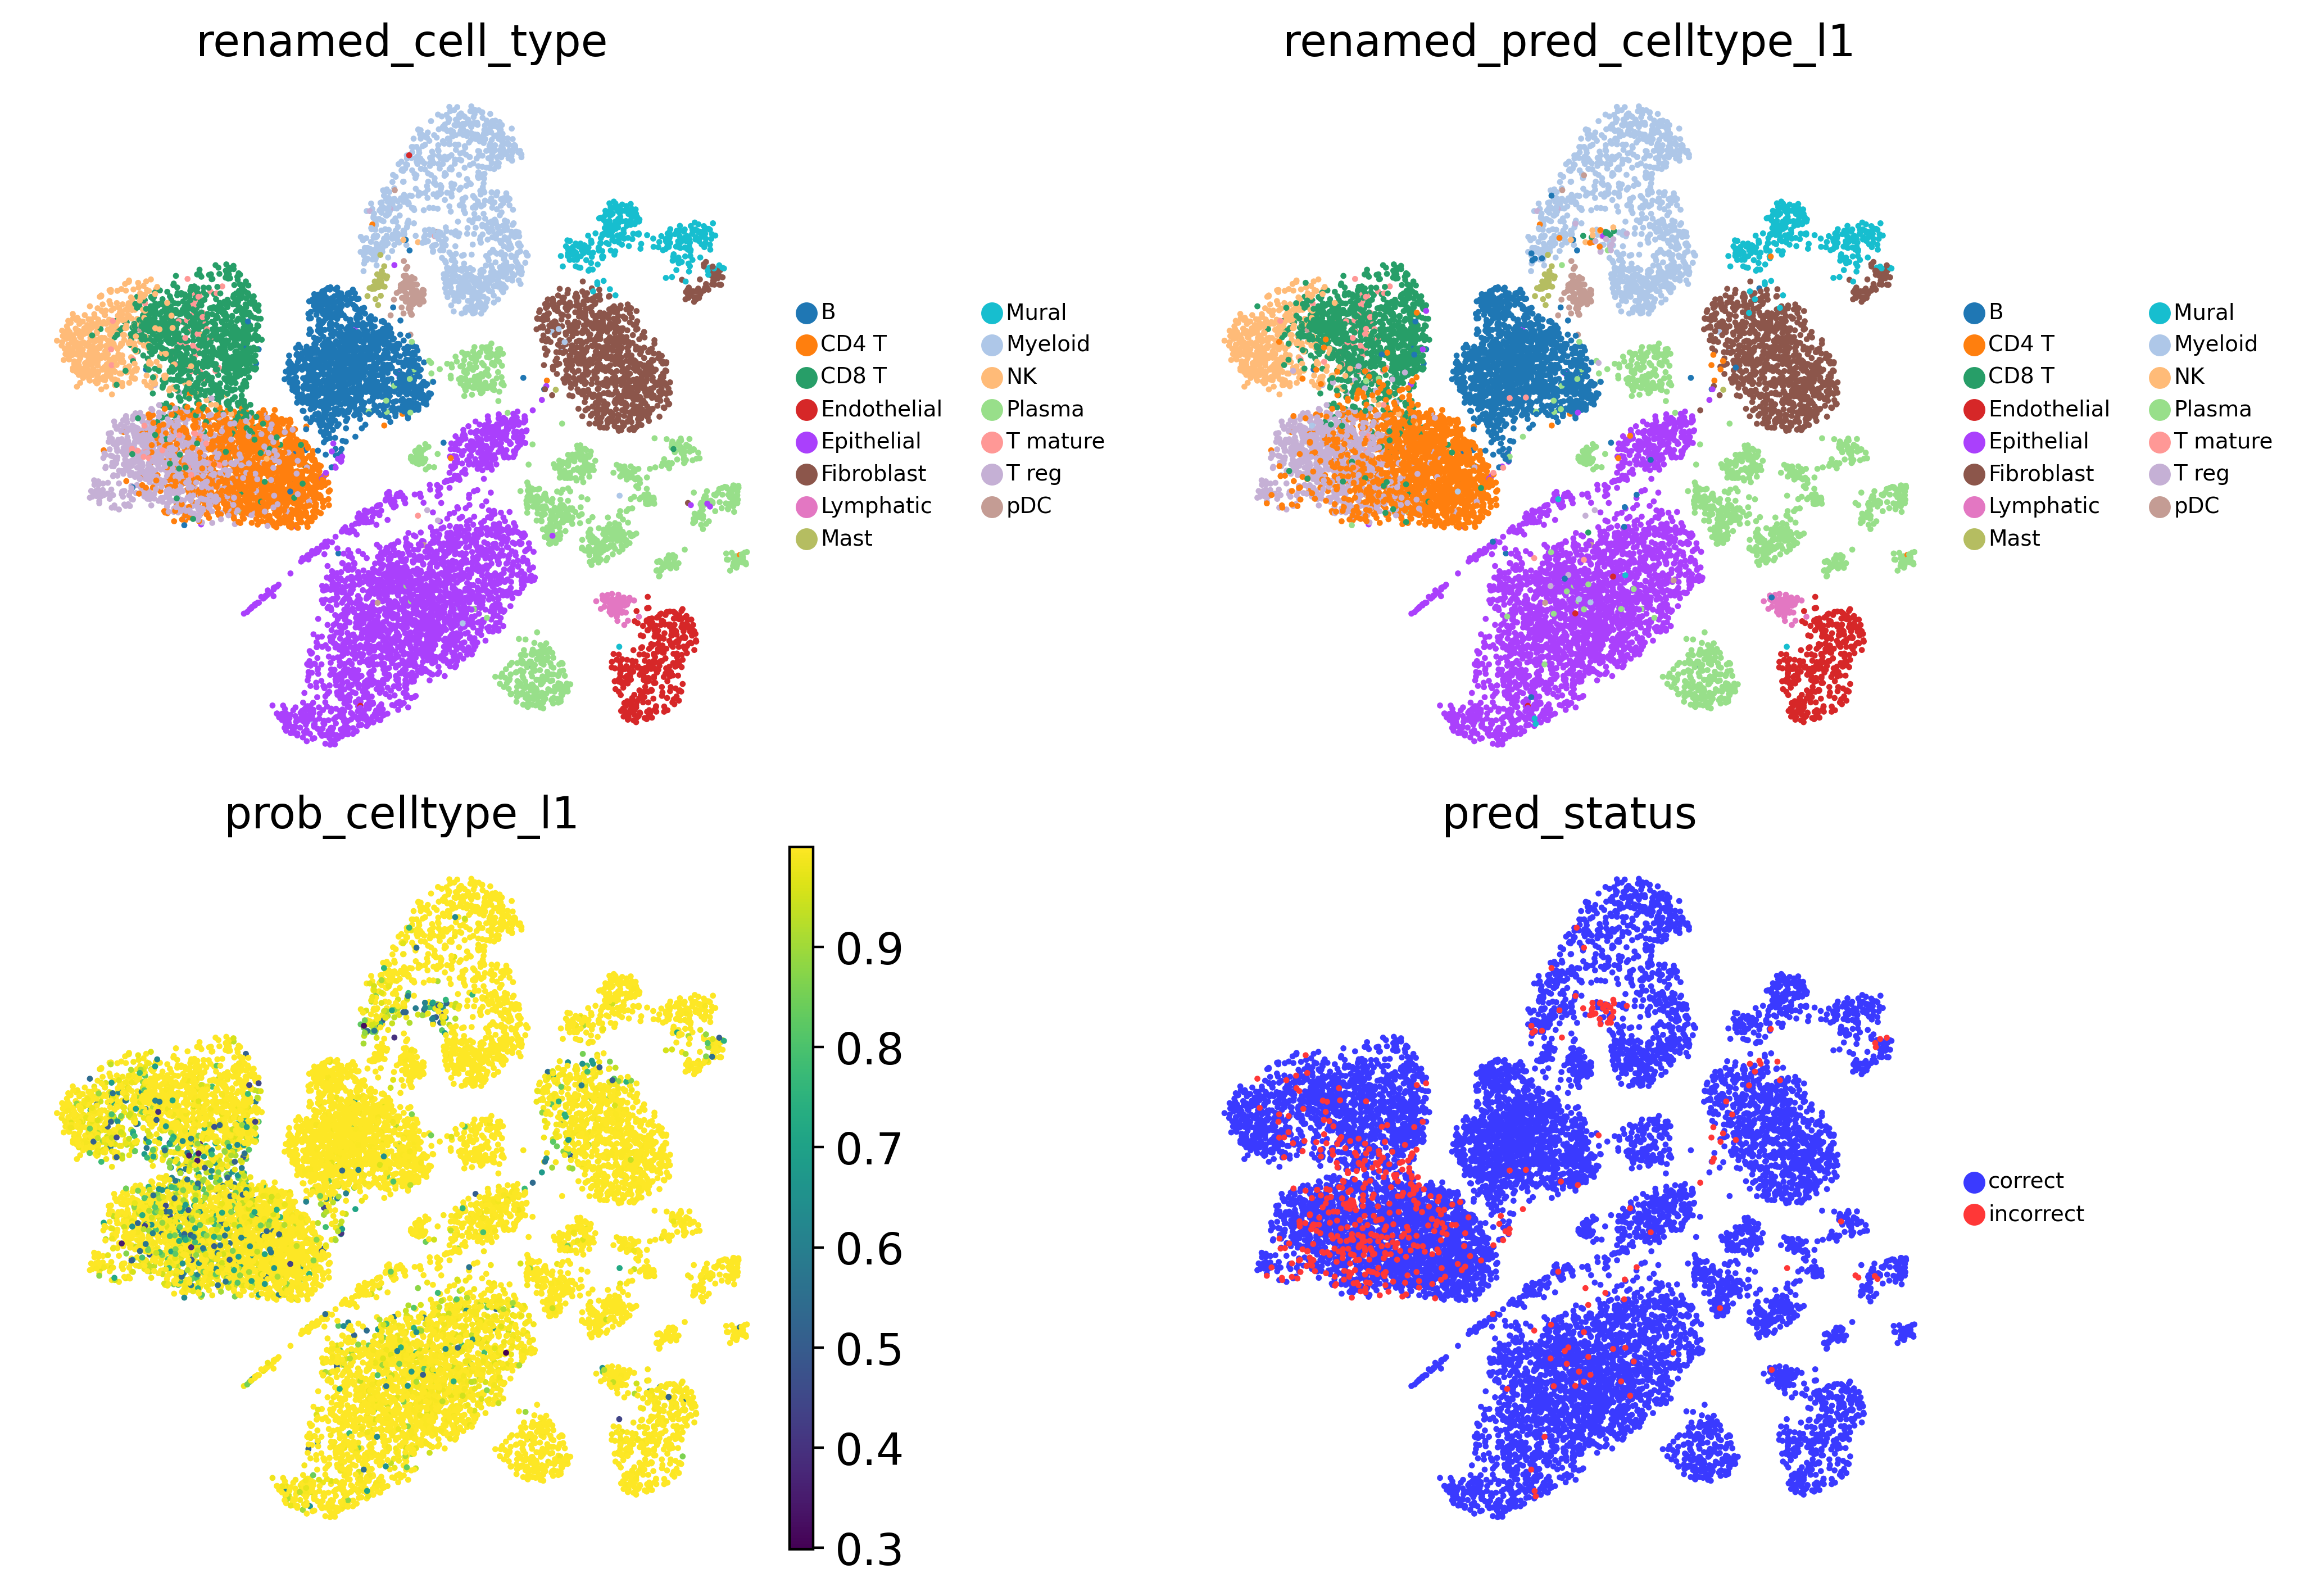

In [54]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
sc.pl.embedding(adata_test_8, 
                color=[
                    'renamed_cell_type',
                    'renamed_pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 15,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_oroph_cancer_scAdam_tuned.png')

In [30]:
import session_info
session_info.show()

# Imbalanced model training

In [66]:
# Train scadam model using adata_train1 dataset
scparadise.scadam.train(adata_train_1,
                        path='', # path to save model
                        model_name='model_oropharyngeal_cancer_scadam_imbalanced', # folder name with model
                        celltype_l1='cell_type',
                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 9757 cells, it is 89.99 % of input dataset
Test dataset contains: 1085 cells, it is 10.01 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 39.62247| val_0_unsup_loss_numpy: 1.801360011100769|  0:00:00s
epoch 1  | loss: 8.76539 | val_0_unsup_loss_numpy: 1.2370699644088745|  0:00:00s
epoch 2  | loss: 3.07857 | val_0_unsup_loss_numpy: 1.2212400436401367|  0:00:01s
epoch 3  | loss: 1.30975 | val_0_unsup_loss_numpy: 1.0893700122833252|  0:00:01s
epoch 4  | loss: 1.04519 | val_0_unsup_loss_numpy: 1.0127999782562256|  0:00:02s
epoch 5  | loss: 0.99576 | val_0_unsup_loss_numpy: 0.988610029220581|  0:00:02s
epoch 6  | loss: 0.97613 | val_0_unsup_loss_numpy: 0.9657999873161316|  0:00:03s
epoch 7  | loss: 0.95191 | val_0_unsup_loss_numpy: 0.9366400241851807|  0:00:03s
epoch 8  | loss: 0.94457 | val_0_unsup_loss_numpy: 0.9145900011062622

In [67]:
# Predict cell types using trained model
for adata_test, j in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Oropharyngeal_cancer/scadam_imbalanced', j))
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_oropharyngeal_cancer_scadam_imbalanced')
    df_default = scparadise.scnoah.report_classif_full(adata_test,
                                                       celltype='cell_type',
                                                       pred_celltype='pred_celltype_l1',
                                                       report_name='report_test_scadam_imbalanced_' + 'cell_type' + '.csv',
                                                       save_path = os.path.join('Oropharyngeal_cancer/scadam_imbalanced', j).replace("\\","/"),
                                                       save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 